In [7]:
""" Faraz Hossein-Babaei   starting 2016/9/26   Eexperiment 1 with python and pandas:
Correlating economies and medal winnings of countries """
""" Data Reading Segment: Reads dataframe from GDP source table and cleans up the table """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Read large large cluster table (has info about gdp, pop, gender, internet users, hospital goers, ...), and clean it
econ_df = pd.read_csv("..\countries_econ.csv", index_col=2)
econ_df.index.name = None
new_cols = econ_df.columns.values
new_cols[0] = "Series Name"
for i in range(3,len(new_cols)):
    new_cols[i] = int(new_cols[i].split(" ")[0])
econ_df.columns = new_cols

# Now, groupby sub-parts of the complex table to isolate tables of interest
econ_df_groupby = econ_df.groupby(econ_df["Series Name"], axis=0)
gdp_df = econ_df_groupby.get_group("GDP (current US$)")
gdp_df = gdp_df.drop(["Series Name","Series Code","Country Code"], axis=1)
gdp_df = gdp_df.replace(to_replace="..", value=0)
gdp_df = gdp_df.astype(float)
gdp_df = gdp_df.replace(to_replace=0, value=np.nan)
pop_df = econ_df_groupby.get_group("Population, total")
pop_df = pop_df.drop(["Series Name","Series Code","Country Code"], axis=1)
pop_df = pop_df.replace(to_replace="..", value=0)
pop_df = pop_df.astype(float)   # had to go cast as float first bcs skipping that step raised error for non-int poplations
pop_df = pop_df.astype(int)     # oddly, columns with NaN therein stay as float64
pop_df = pop_df.replace(to_replace=0, value=np.nan)


In [8]:
""" Plot Preparation Function Segment: A helper function for drawing graphs to make code shorter """

def prepare_plot (knd, ax, df, ttl, x_lbl, y_lbl, x_tick_lbls, lgd_lbls, clr_map, \
                  ln_styl, ln_wd, mrk, mrk_sz, atten, txt_bool, x_x, idxs):
    """ Function to plot a DataFrame. Each row is plotted as a curve in cartesian
     coordinates. .columns forms x-axis values. """
    
    font = {'font.family':'Arial', 'font.weight':'normal', 'font.size':22}
    
    color_map = clr_map   # matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
    clrs_dict = {}   # other color maps: brg, spectral, Accent, Paired, gnuplot, bone, hsv, jet, gist_ncar
    num_plots = len(idxs)
    cnt = 0
    for idx in idxs:   # Building dict of colors: traversing all unique indices of the df(s) in the data to plot
        cur_num = 1.0*cnt / float(num_plots)
        if cur_num > 1: cur_num -= 1
        clrs_dict[idx] = color_map( cur_num )
        cnt += 1
    
    plt.rcParams.update(font)
    
    for _,idx in enumerate(df.index):
        ax.plot( df.loc[idx,:], color=clrs_dict[idx], linewidth=ln_wd, linestyle=ln_styl, marker=mrk, \
                  markerfacecolor=clrs_dict[idx], markersize=mrk_sz, alpha=atten)
    
    plt.suptitle(ttl, fontsize=36)
    plt.xlabel(x_lbl)
    plt.ylabel(y_lbl)
    plt.ylim(bottom=0)
    plt.xlim(df.columns[0]+x_x[0], df.columns[-1]+x_x[1])
    plt.xticks(df.columns, x_tick_lbls, rotation='vertical')
    
    if len(lgd_lbls) > 0:
        legend = plt.legend( lgd_lbls, ncol=1, loc='best', fontsize=16, \
                   columnspacing=1.5, labelspacing=0.5, handletextpad=0.5, handlelength=1.5, \
                   fancybox=True, shadow=True )
    
    return ax


In [41]:
""" Segment of reformatting economy tables to match the Olympics tables formats """

# Read table used for mapping country names (Olympics or econ format) to IOC codes
#########ioc_df = pd.read_csv("ioc country codes corrected.tsv", sep='\t', index_col=0)   # col 0 is Country names
#ioc_df["Ctr_Name"] = ioc_df.index
#ioc_df.to_csv("ioc country codes corrected_2.tsv", sep='\t')
#ctr_name_discreps = gdp_df[~gdp_df.index.isin(ioc_df.index)].index.values.tolist()

# Above commented code revealed that 44 country name discrepencies were found. Manually, "ioc country
    # codes corrected_2.tsv" was supplied with gdp names to match
ioc_df = pd.read_csv("ioc country codes corrected_2.tsv", sep='\t', index_col=4)   # col 0 is Country names
ctr_name_discreps = gdp_df[~gdp_df.index.isin(ioc_df.index)].index.values.tolist()
#print (len(ctr_name_discreps), ctr_name_discreps)   # No discrepency this time

# Here, we convert index of country names to one of IOC (3-letter codes) matching our Olympics tables' formats
gdp_df["Country"] = gdp_df.index   # This col is for later IOC indexing the table
pop_df["Country"] = gdp_df.index   # This col is for later IOC indexing the table
gdp_df["IOC"] = gdp_df["Country"].map(ioc_df["IOCode"])   # Derive NOC codes from name and set_index
pop_df["IOC"] = pop_df["Country"].map(ioc_df["IOCode"])   # Derive NOC codes from name and set_index
gdp_df["IOC"].fillna(gdp_df["Country"], inplace=True)
pop_df["IOC"].fillna(pop_df["Country"], inplace=True)
gdp_df.set_index(gdp_df["IOC"], inplace=True)
pop_df.set_index(pop_df["IOC"], inplace=True)
gdp_df.index.name, pop_df.index.name = None, None
gdp_df.drop(["Country","IOC"], axis=1, inplace=True)
pop_df.drop(["Country","IOC"], axis=1, inplace=True)

# Define metrics for economy shares across globe tables of global shares of gdp and population each year
gdp_share_df = gdp_df / gdp_df.sum(axis=0)
pop_share_df = pop_df / pop_df.sum(axis=0)   # This isn't used for the correlation analysis. It is a cool table in itself though.
# Now, create new metrics: the gdp/pop ratios of different degrees for empirical observation
pw = [1, 0.5, 0.2]   # Powers to excite population to before dividing gdp by it
gdppc1_df = gdp_df / (pop_df**pw[0])   # When operating among the dfs, I assume not only they have same size, but also same index
gdppc2_df = gdp_df / (pop_df**pw[1])
gdppc3_df = gdp_df / (pop_df**pw[2])
gdppc1_share_df = gdp_df / (pop_df**pw[0] * gdppc1_df.sum(axis=0))
gdppc2_share_df = gdp_df / (pop_df**pw[1] * gdppc2_df.sum(axis=0))
gdppc3_share_df = gdp_df / (pop_df**pw[2] * gdppc3_df.sum(axis=0))

# Grouping into bins the data of scores
bins = list(range(1960,2020,4)) # list of years to which data be grouped-averaged; for new column headings too
binned_yrs_idxs = np.digitize(x=gdp_df.columns.values.tolist(), bins=bins, right=True)   # They all have same columns
gdp_df_grpby = gdp_df.groupby(binned_yrs_idxs, axis=1)   # GDPs of countries
pop_df_grpby = pop_df.groupby(binned_yrs_idxs, axis=1)   # Populations of countries
gdp_share_df_grpby = gdp_share_df.groupby(binned_yrs_idxs, axis=1)   # GDPs of countries
pop_share_df_grpby = pop_share_df.groupby(binned_yrs_idxs, axis=1)   # Populations of countries
gdppc1_df_grpby = gdppc1_df.groupby(binned_yrs_idxs, axis=1)   # GDP/population
gdppc2_df_grpby = gdppc2_df.groupby(binned_yrs_idxs, axis=1)   # GDP/(population ^ 0.5)
gdppc3_df_grpby = gdppc3_df.groupby(binned_yrs_idxs, axis=1)   # GDP/(population ^ 1.5)
gdppc1_share_df_grpby = gdppc1_share_df.groupby(binned_yrs_idxs, axis=1)   # GDP/population
gdppc2_share_df_grpby = gdppc2_share_df.groupby(binned_yrs_idxs, axis=1)   # GDP/(population ^ 0.5)
gdppc3_share_df_grpby = gdppc3_share_df.groupby(binned_yrs_idxs, axis=1)   # GDP/(population ^ 1.5)


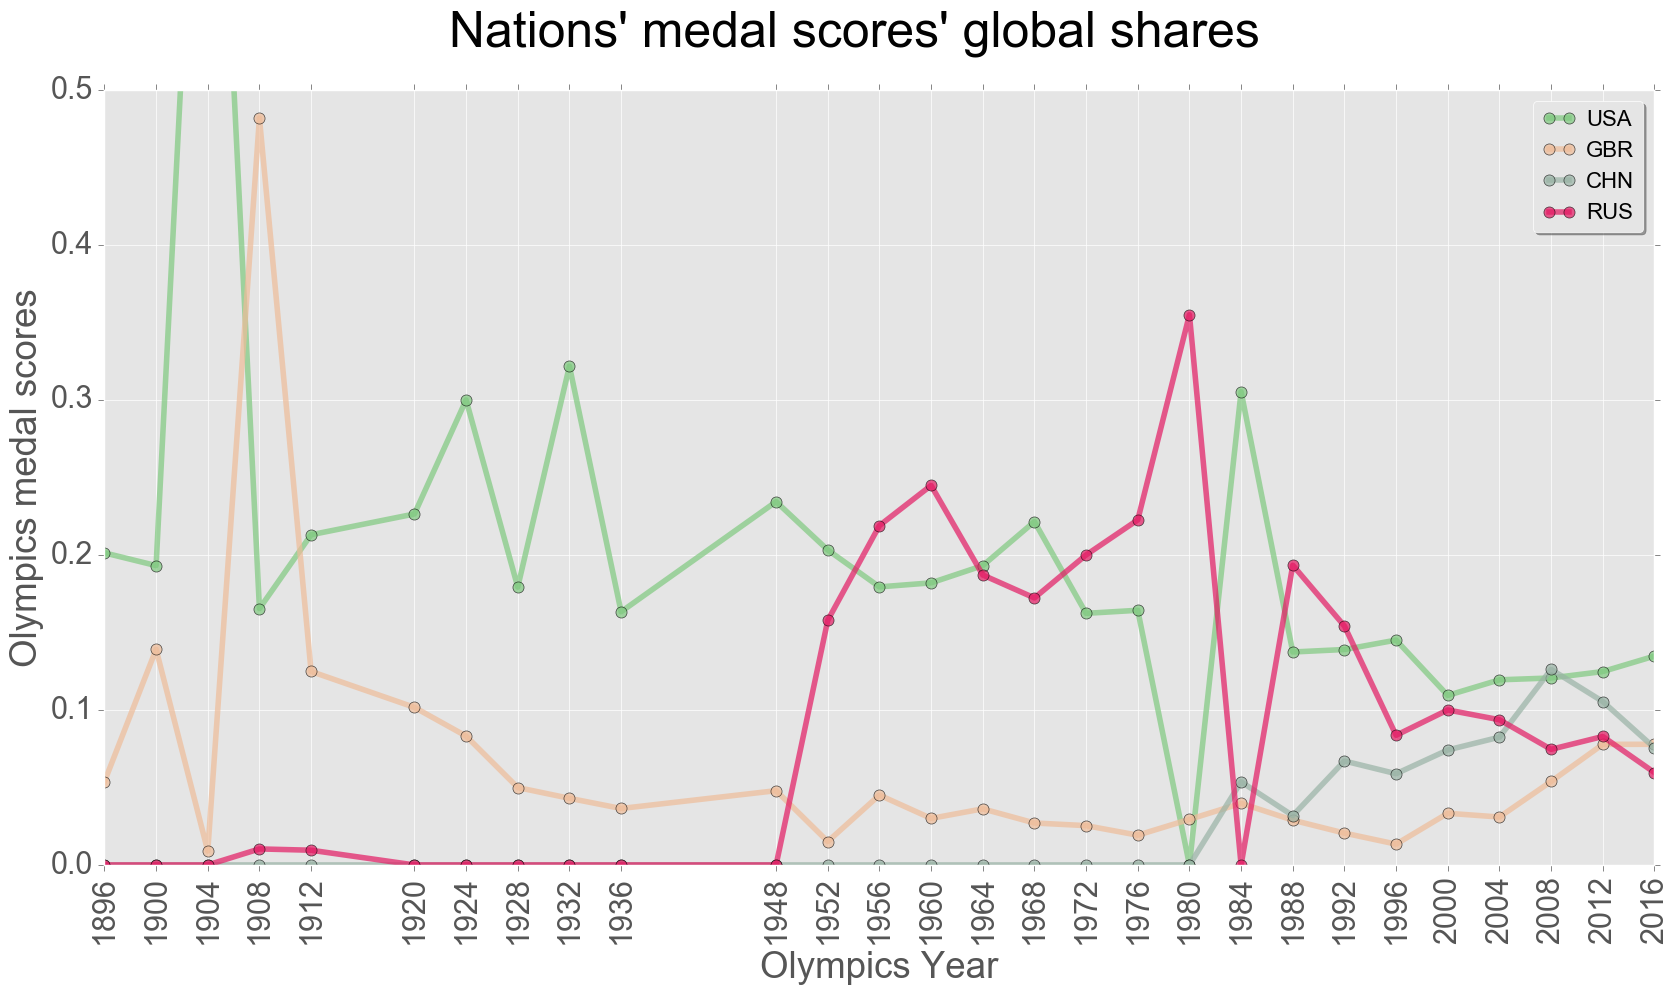

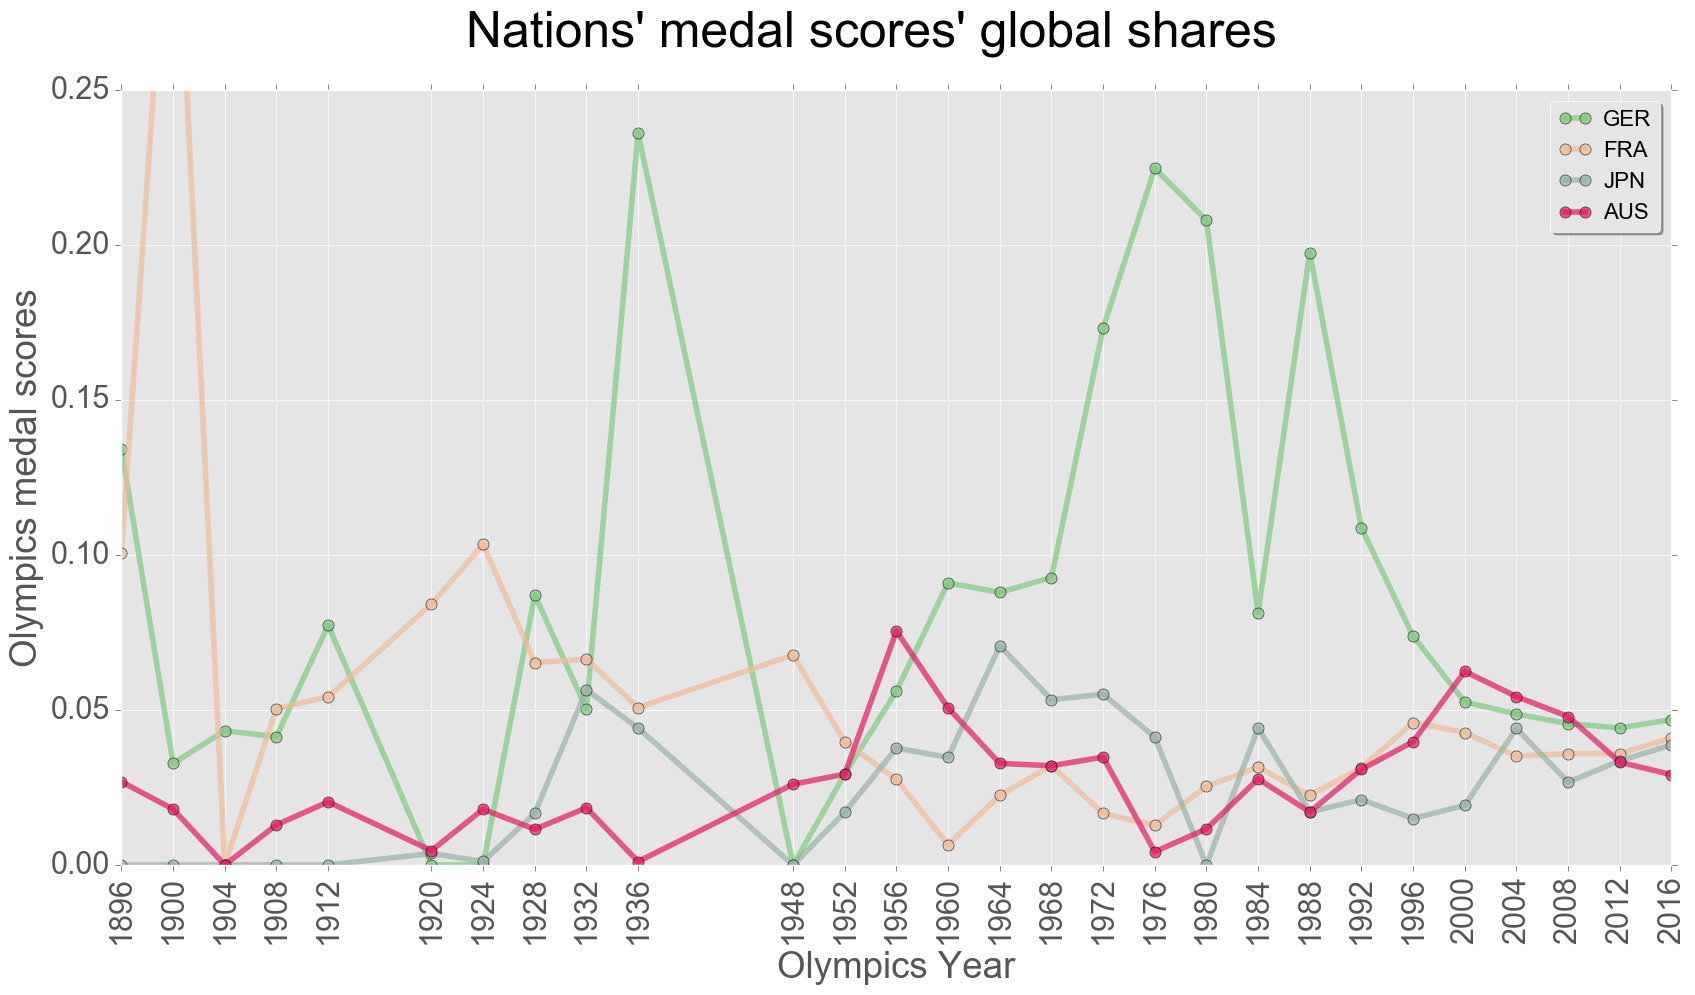

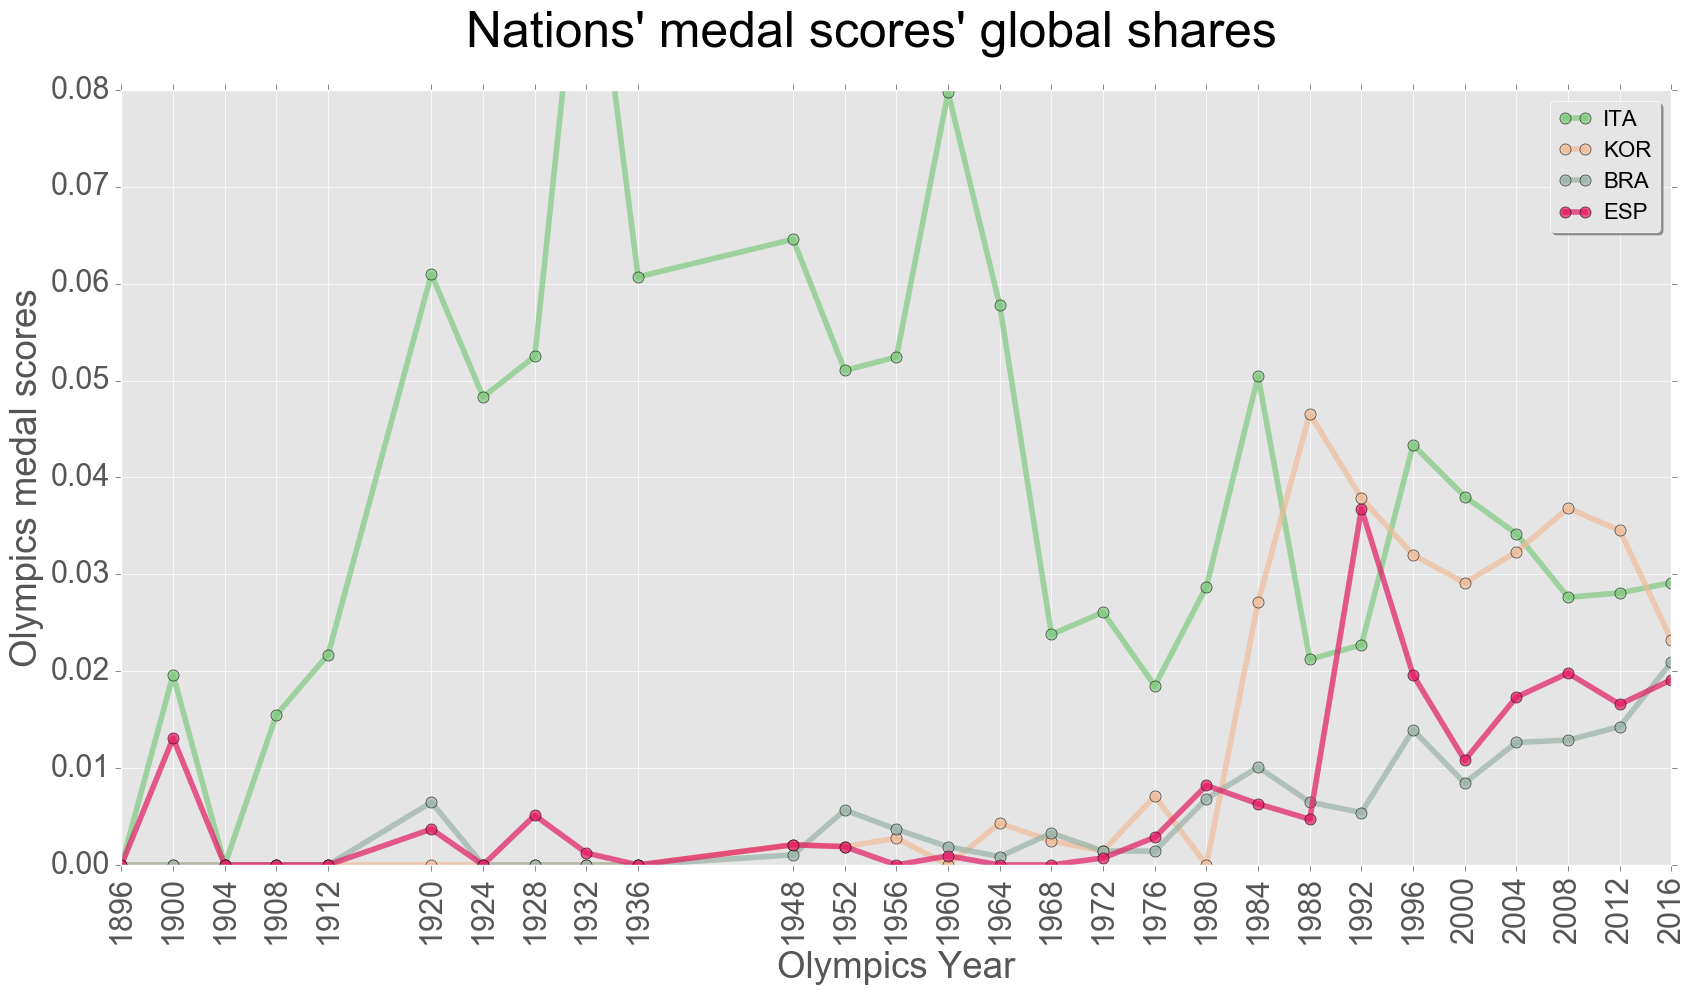

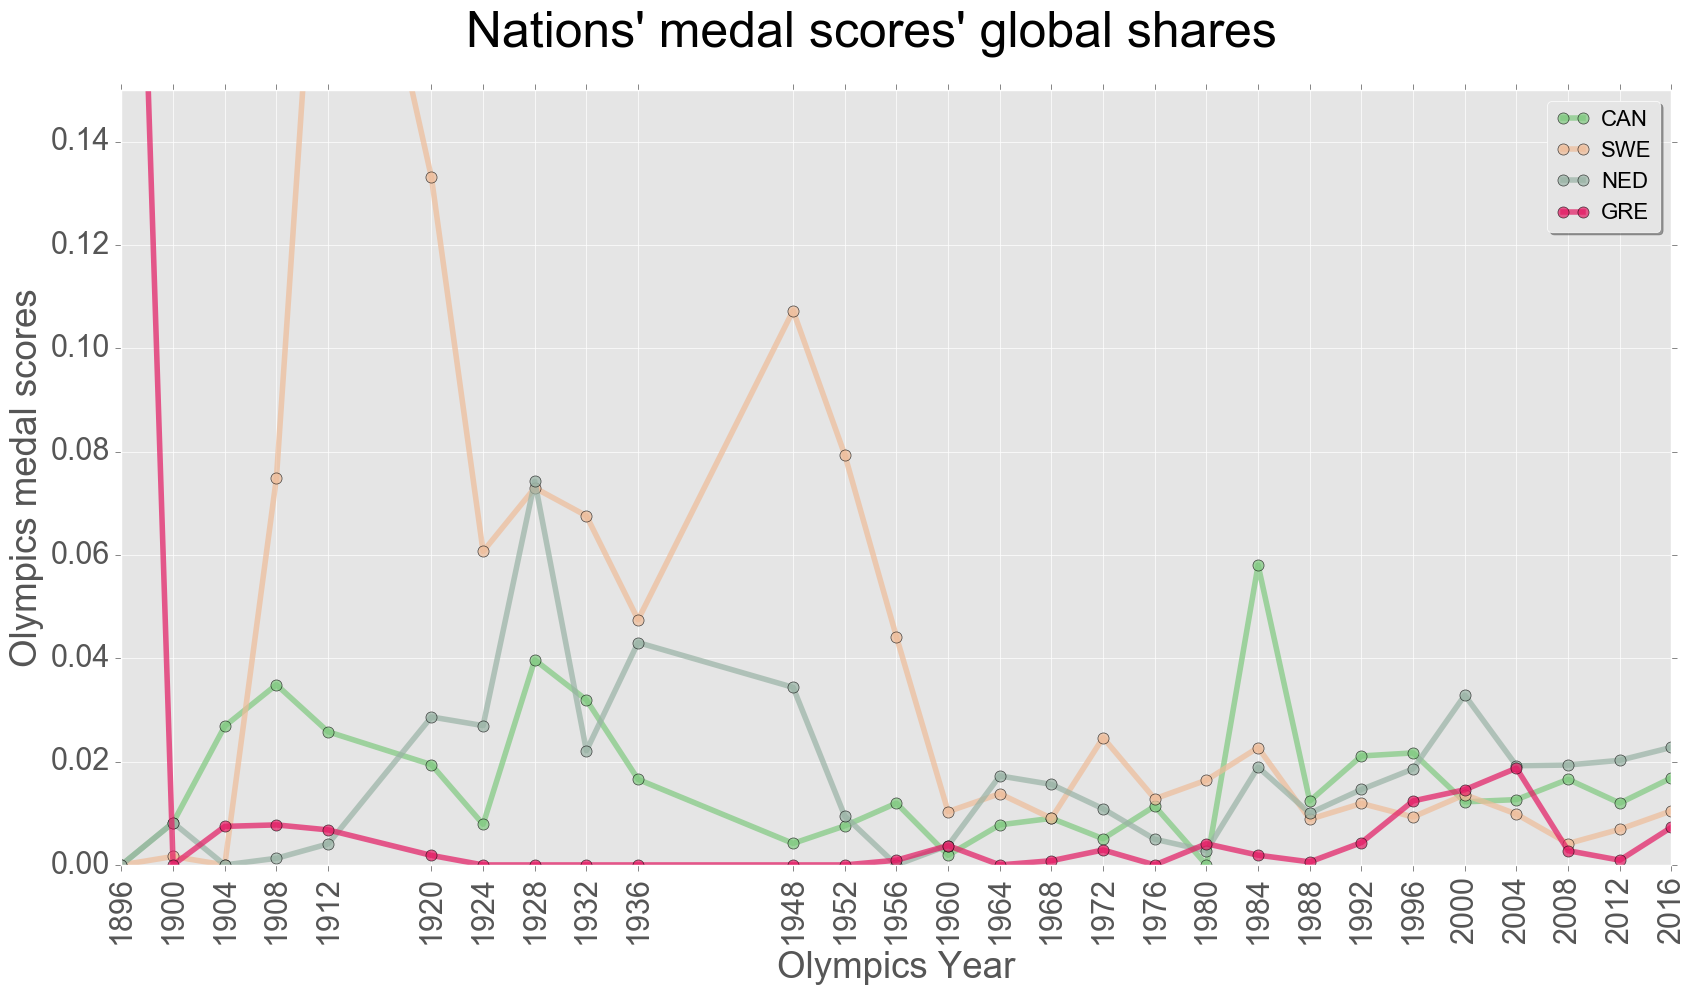

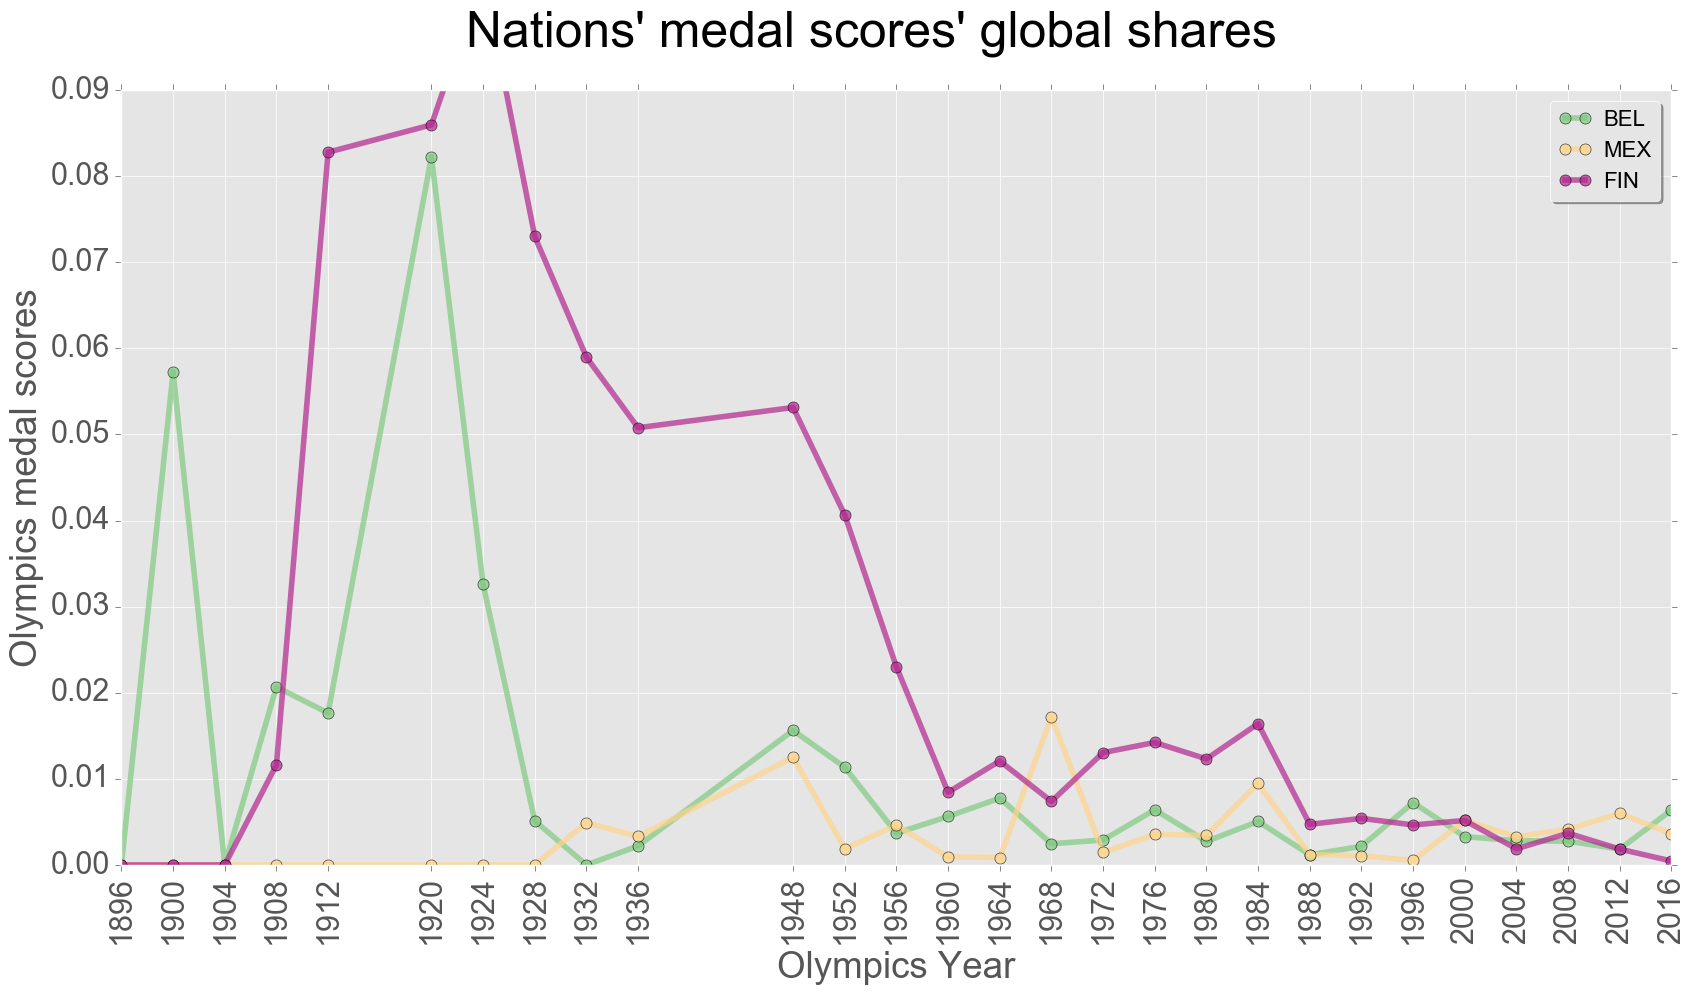

Figure 5 a-e: Medal score global share trends of 19 nations, all hosts of Summer Olympics games.


In [46]:
""" Segment for matching Olympics and GDP data formats """

# Read table used for mapping country names (Olympics or econ format) to IOC codes
medal_scores_df = pd.read_csv("all_ctrs_df.csv", index_col=0)
medal_shares_df = pd.read_csv("all_shares_df.csv", index_col=0)

# Loading Olympics data from files prepared from medals_gdp_2.ipynb
all_ctrs_df = pd.read_csv("all_ctrs_df.csv", index_col=0)
all_shares_df = pd.read_csv("all_shares_df.csv", index_col=0)
# Olympics data column headings to int
all_ctrs_df.columns = [int(x) for x in all_ctrs_df.columns.values.tolist()]
all_shares_df.columns = [int(x) for x in all_shares_df.columns.values.tolist()]

# Plotting 1896-2016 Olympics medal score shares data
all_shares_cmplt_df = all_shares_df
all_shares_cmplt_top_df = all_shares_cmplt_df.sort_values([2016,2004], ascending=[False,False])
olymp_yrs = all_shares_cmplt_df.columns.values.tolist()


def adjust_ybounds (axes, fig_idx):
    axes.set_ybound(upper=PLOTS_YBOUND_TOPS[fig_idx])
# select_ctrs_df: Plotting temporal medal trends as countries' medal scores
hosts = ["USA","GBR","CHN","RUS","GER","FRA","JPN","AUS","ITA","KOR","BRA","ESP","CAN","SWE","NED",\
         "GRE","BEL","MEX","FIN"]   # list manually put in order of highest peak value descending
plt.style.use('ggplot')
PLOTS_YBOUND_TOPS = (0.5, 0.25, 0.08, 0.15, 0.09)
for i in range(0,5):
    conations = [hosts[j] for j in range(4*i,min(4*i+4,len(hosts)))]
    sub_shares_df = all_shares_cmplt_top_df.loc[conations, :]
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    plot_ax = prepare_plot("line", ax, sub_shares_df, "Nations' medal scores' global shares" , \
                 "Olympics Year" , "Olympics medal scores", \
                 olymp_yrs, sub_shares_df.index , plt.cm.Accent, '-', 4.0, 'o', 8.0, 0.7, \
                 False, (0,0), sub_shares_df.index)
    adjust_ybounds(plot_ax, i)
    plt.show()

print ("Figure 5 a-e: Medal score global share trends of 19 nations, all hosts of Summer Olympics games.")

# Back to our main point of formatting the Olympic data for correlation with economies
all_ctrs_df = all_ctrs_df.loc[:, 1960:]       # limiting the time to post-1960 to match GDP data
all_shares_df = all_shares_df.loc[:, 1960:]   # limiting the time to post-1960 to match GDP data
# Note: all_ctrs_df, all_shares_df  res files have come from medals_gdp_2 notebook


In [47]:
""" Medal Trends Data preparation Segment: Preparing data for temporal medal trends of countries. """

# Get some output with economically high-ranking nations
g3_4y_share_df = gdppc3_share_df_grpby.mean()
g3_4y_share_df.columns = bins
g3_4y_share_df = g3_4y_share_df.sort_values([2016,2004], ascending=[False,False])
print ("Table: Top nations and global share of their GDP/population(0.2) metric, 2016 ranked. (Data from World")
print ("Development Indicators, http://databank.worldbank.org/data/reports.aspx?source=world-development-indicators, last updated 2016-8-10)")
print (g3_4y_share_df[[1960,1996,2016]].head(n=8))   # If they show as basic ints like 0,1,... don't worry. They are float
print ()
# Get some output with Olympics-wise high-ranking nations
all_shares_top_df = all_shares_df.sort_values([2016,2004], ascending=[False,False])
print ("Table: Top nations and global share of their Olympic medal score metric, 2016 ranked. (Data from World")
print ("Development Indicators, http://databank.worldbank.org/data/reports.aspx?source=world-development-indicators, last updated 2016-8-10)")
print (all_shares_top_df[[1960,1996,2016]].head(n=8))


Table: Top nations and global share of their GDP/population(0.2) metric, 2016 ranked. (Data from World
Development Indicators, http://databank.worldbank.org/data/reports.aspx?source=world-development-indicators, last updated 2016-8-10)
      1960   1996   2016
USA 0.3843 0.2032 0.1835
CHN 0.0322 0.0128 0.0812
JPN 0.0358 0.1523 0.0576
GER    nan 0.0802 0.0507
GBR 0.0655 0.0435 0.0415
FRA 0.0581 0.0543 0.0388
ITA 0.0369 0.0427 0.0298
CAN 0.0461 0.0252 0.0282

Table: Top nations and global share of their Olympic medal score metric, 2016 ranked. (Data from World
Development Indicators, http://databank.worldbank.org/data/reports.aspx?source=world-development-indicators, last updated 2016-8-10)
      1960   1996   2016
USA 0.1820 0.1451 0.1347
GBR 0.0300 0.0134 0.0778
CHN 0.0000 0.0589 0.0756
RUS 0.2448 0.0836 0.0596
GER 0.0910 0.0738 0.0469
FRA 0.0066 0.0459 0.0410
JPN 0.0347 0.0150 0.0387
AUS 0.0507 0.0398 0.0291


In [48]:
""" Simple Plot Preparation Function Segment: for drawing graphs """

def prepare_simple_plot (fig_idx, ax, x_vals, y_vals, ttl, x_lbl, y_lbl, x_tick_lbls, lgd_lbls, clr, \
                  ln_styl, ln_wd, mrk, mrk_sz, atten, idxs, ax_clr):
    """ Function to plot a DataFrame. Each row is plotted as a curve in cartesian
     coordinates. .columns forms x-axis values. """
    # TODO: Make a subclass of the class I employ here, for flexibility and not passing so much argument at once

    font = {'font.family':'Arial', 'font.weight':'normal', 'font.size':22}
    plt.rcParams.update(font)
    
    ax.plot(x_vals, y_vals, color=clr, linewidth=ln_wd, linestyle=ln_styl, marker=mrk, \
            markerfacecolor=clr, markersize=mrk_sz, alpha=atten)
    
    
    plt.suptitle(ttl, fontsize=36)
    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl, color=ax_clr)
    ax.yaxis.label.set_color(ax_clr)
    ax.tick_params(axis='y', colors=ax_clr)
    ax.set_ybound(lower=0)
    ax.set_xbound(x_vals[0], x_vals[-1]+4)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_tick_lbls, rotation='vertical')
    
    if len(lgd_lbls) > 0:
        legend = ax.legend( lgd_lbls, ncol=2, loc='best', fontsize=16, bbox_to_anchor=[0.7, 0.95], \
                   columnspacing=1.0, labelspacing=0.5, handletextpad=0.0, handlelength=1.5, \
                   fancybox=True, shadow=True )
    
    return


In [49]:
""" Segment for preparing data to plot """

def plot_ctr_gdp_olymp_jux (ctr_grp):
    """ Plotting trends of and fits to economy and Olympics performace shares of nations. """
    
    finite_mask = np.isfinite(g3_4y_share_df.loc[ctr_grp,:].iloc[0,:].tolist())
    xR_expr = g3_4y_share_df.columns.values.tolist()
    xL_expr = [j for i,j in enumerate(xR_expr) if finite_mask[i]]   # applying the bool mask filter
    yL_expr = g3_4y_share_df.loc[ctr_grp,:].iloc[0,:].tolist()
    yL_expr = [j for i,j in enumerate(yL_expr) if finite_mask[i]]
    yR_expr = all_shares_df.loc[ctr_grp,:].iloc[0,:].tolist()
    x_cont = np.linspace(xR_expr[0], xR_expr[-1]+2, 100)   # a[0] is min(a), a[-1] is max(a); sorted!
    xL_cont = np.linspace(xL_expr[0], xL_expr[-1]+2, 100)
    xR1 = [x for x in x_cont if x <= xR_expr[-1]]
    xL1 = [x for x in xL_cont if x <= xL_expr[-1]]
    xL2 = [x for x in xL_cont if x >= xL_expr[-1]-0.5]   # -0.5 to have continuity
    
    # get curve fit functions
    p_fit_L = np.polyfit(xL_expr, yL_expr, deg=5)
    p_fit_R = np.polyfit(xR_expr, yR_expr, deg=5)
    
    COLOR_1 = "#ee7700"
    COLOR_2 = "#77cc22"
    COLOR_1_AX = "#ee7700"
    COLOR_2_AX = "#55bb11"
    COLOR_1_PTS = "#dd8822"
    COLOR_2_PTS = "#99dd00"
    
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    
    # polynomial fit to GDP data
    prepare_simple_plot(1, ax1, xL1, np.poly1d(p_fit_L)(xL1), "" , \
                 "" , "", \
                 g3_4y_share_df.columns, [] , COLOR_1, '-', 4.0, 'None', 10.0, 0.7, \
                 g3_4y_share_df.index, COLOR_1_AX)
    # polynomial fit to Olympic data
    prepare_simple_plot(1, ax2, xR1, np.poly1d(p_fit_R)(xR1), "" , \
                 "" , "", \
                 g3_4y_share_df.columns, [] , COLOR_2, '-', 4.0, 'None', 10.0, 0.7, \
                 g3_4y_share_df.index, COLOR_2_AX)
    # Extrapolating GDP data
    prepare_simple_plot(1, ax1, xL2, np.poly1d(p_fit_L)(xL2), "" , \
                 "" , "", \
                 g3_4y_share_df.columns, [] , COLOR_1, '--', 4.0, 'None', 10.0, 0.7, \
                 g3_4y_share_df.index, COLOR_1_AX)
    # Actual GDP data
    prepare_simple_plot(1, ax1, xL_expr, yL_expr, "" , \
                 "Olympics Year" , "GDP/pop^0.2 global share", \
                 xL_expr, [], COLOR_1_PTS, '', 4, 'o', 10, 0.9, \
                 g3_4y_share_df.index, COLOR_1_AX)
    # Actual Olympics data
    prepare_simple_plot(1, ax2, xR_expr, yR_expr, "Economic and Olympic performances of "+ctr_grp[0] , \
                 "Olympics Year" , "Olympics medal score share", \
                 xR_expr, [], COLOR_2_PTS, '', 4, 'd', 10, 0.9, \
                 all_shares_df.index, COLOR_2_AX)
    
    return [ax1,ax2]


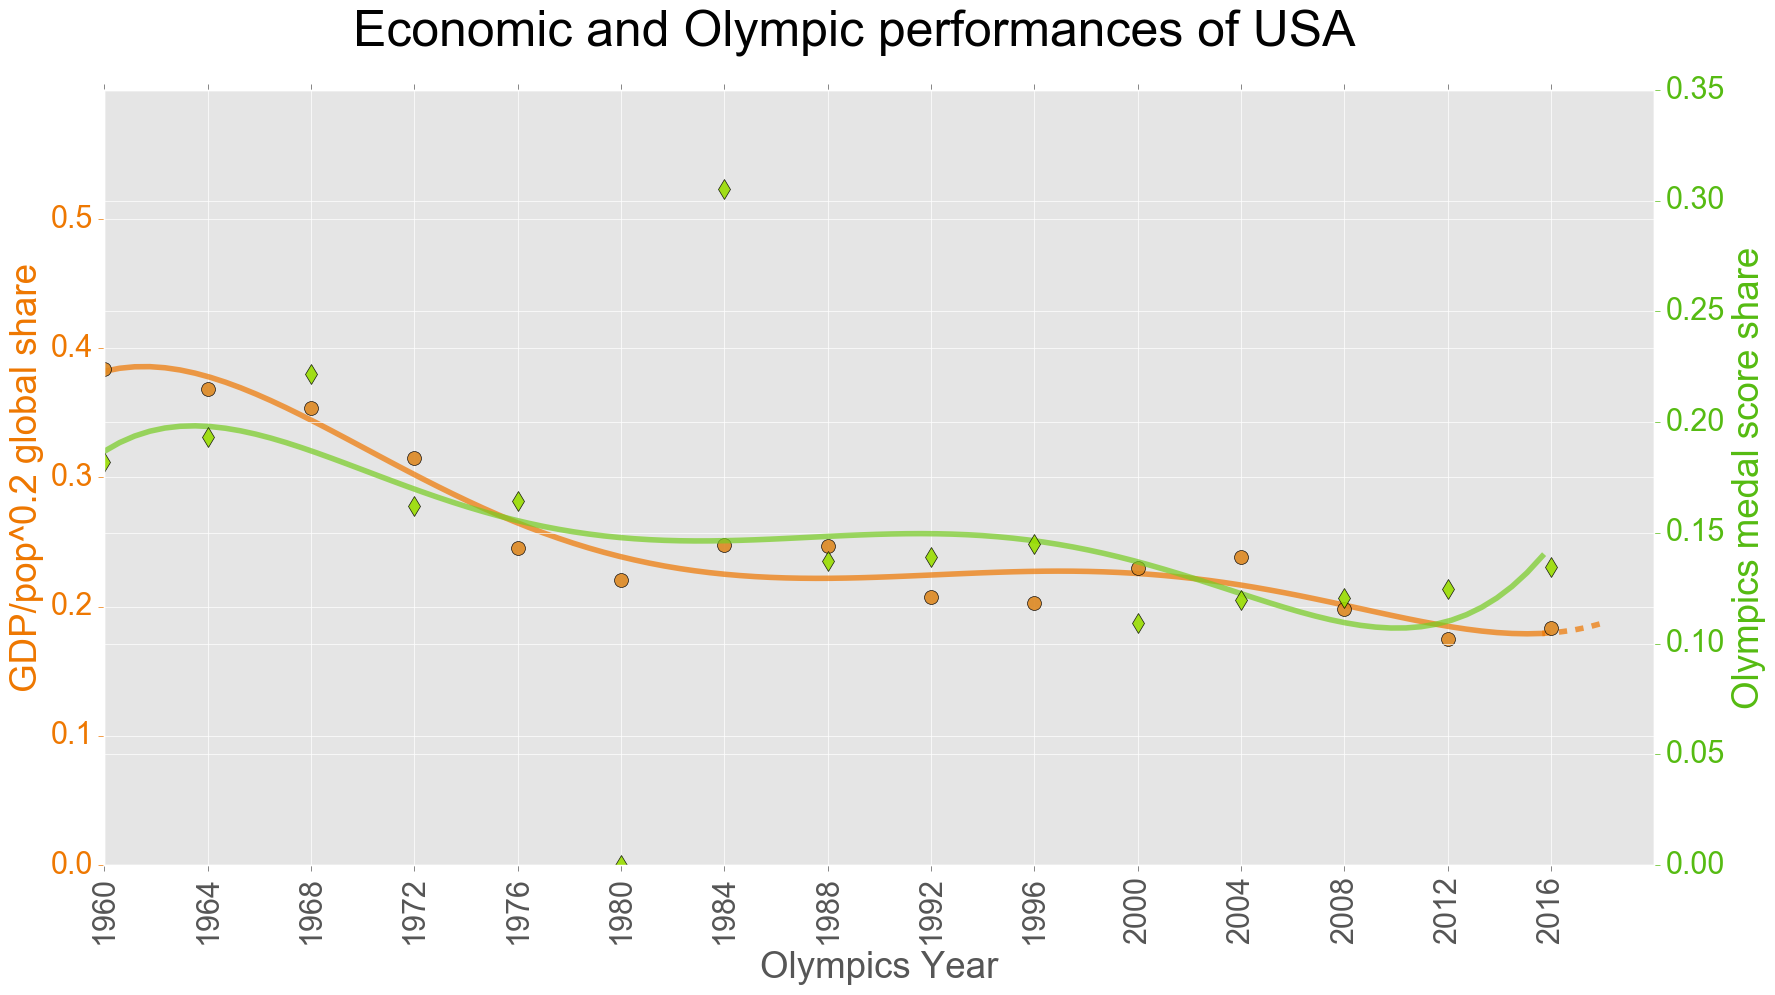

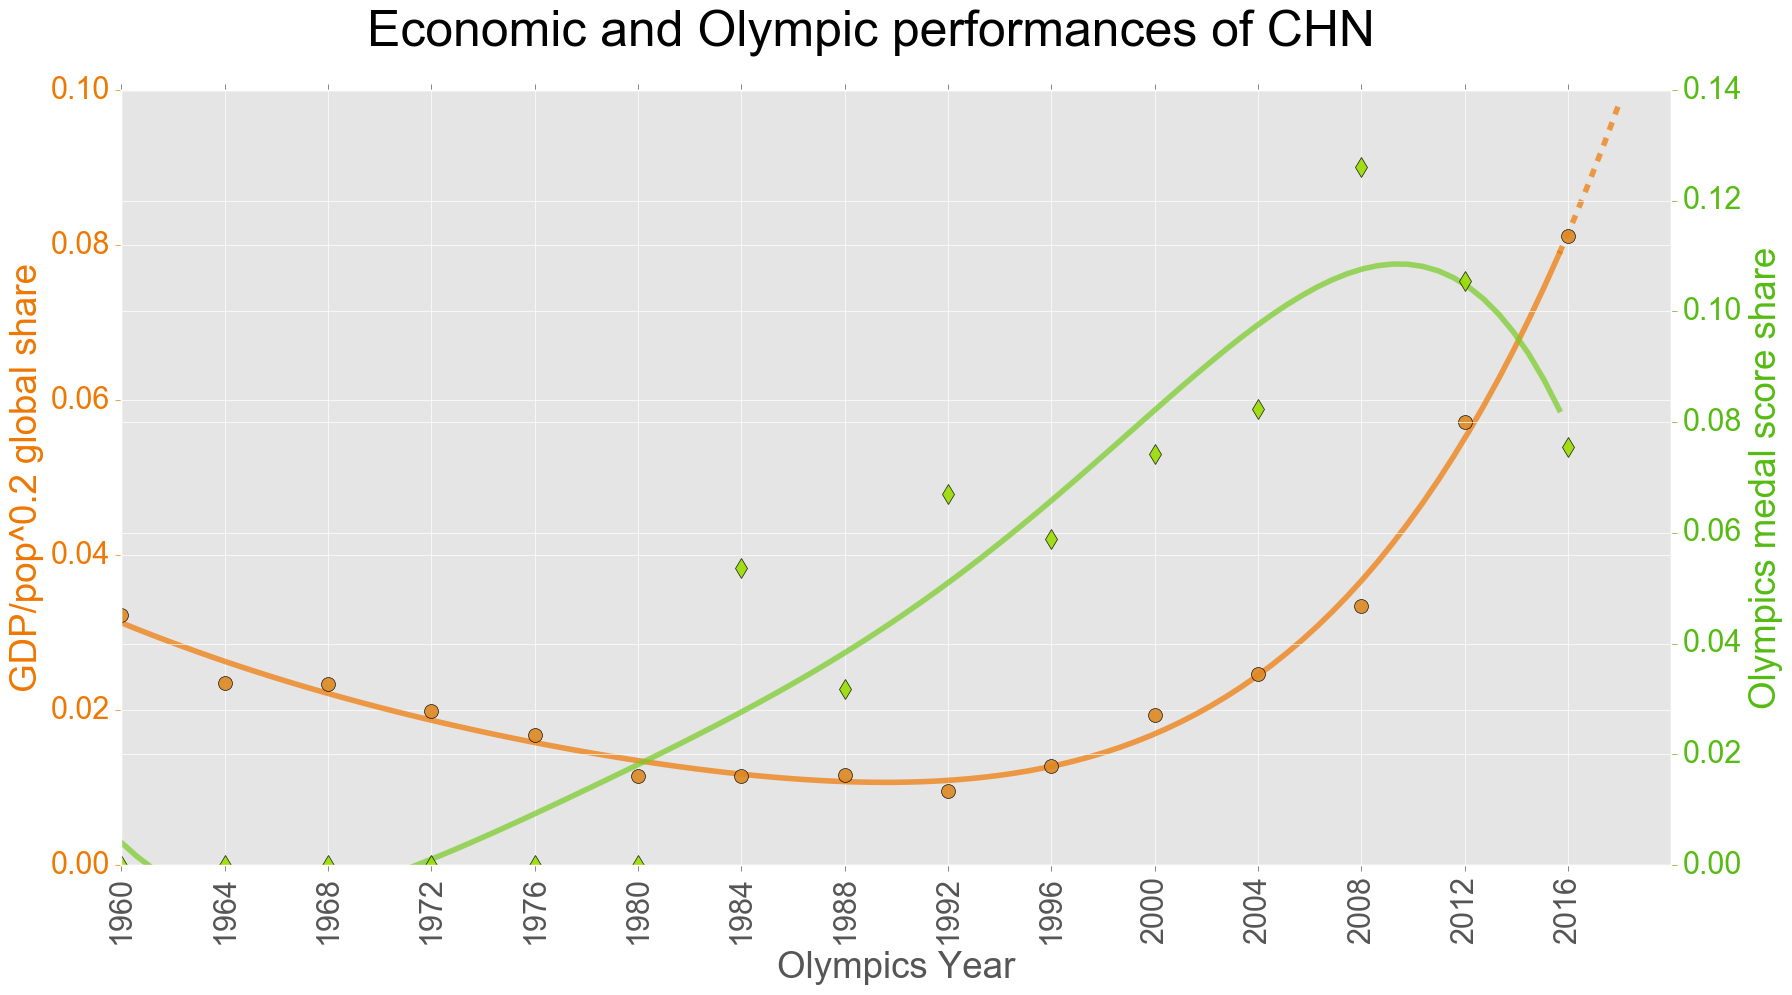

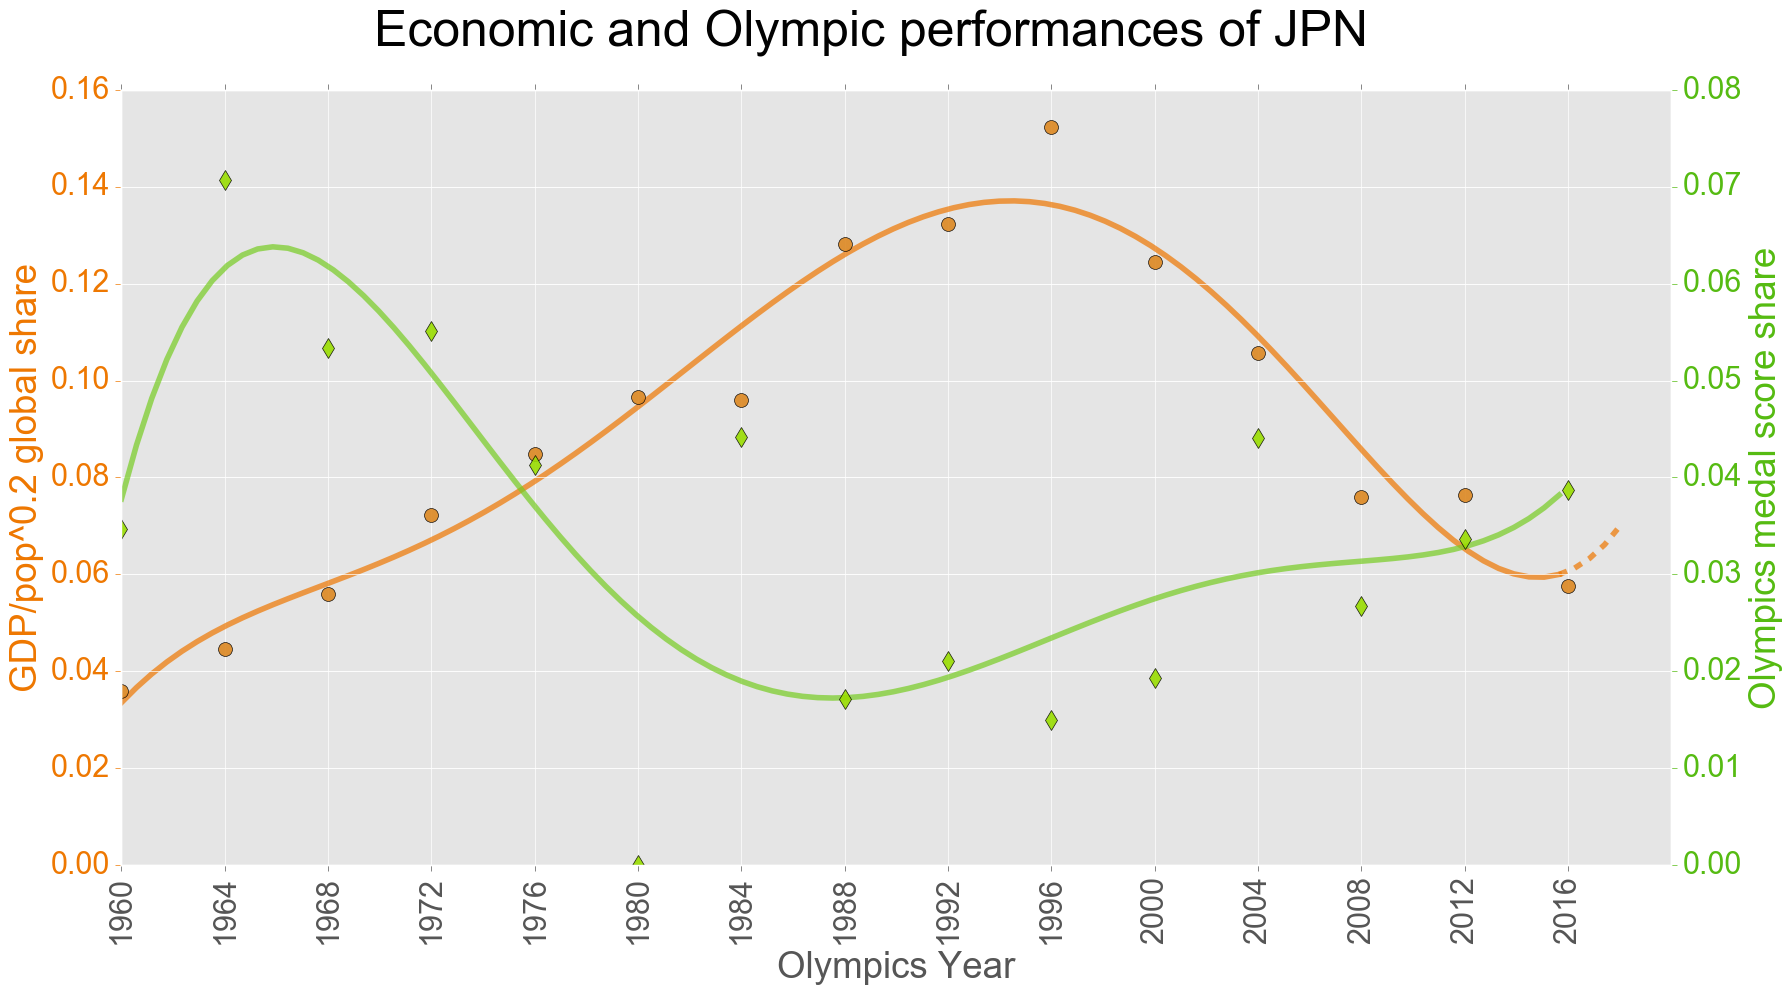

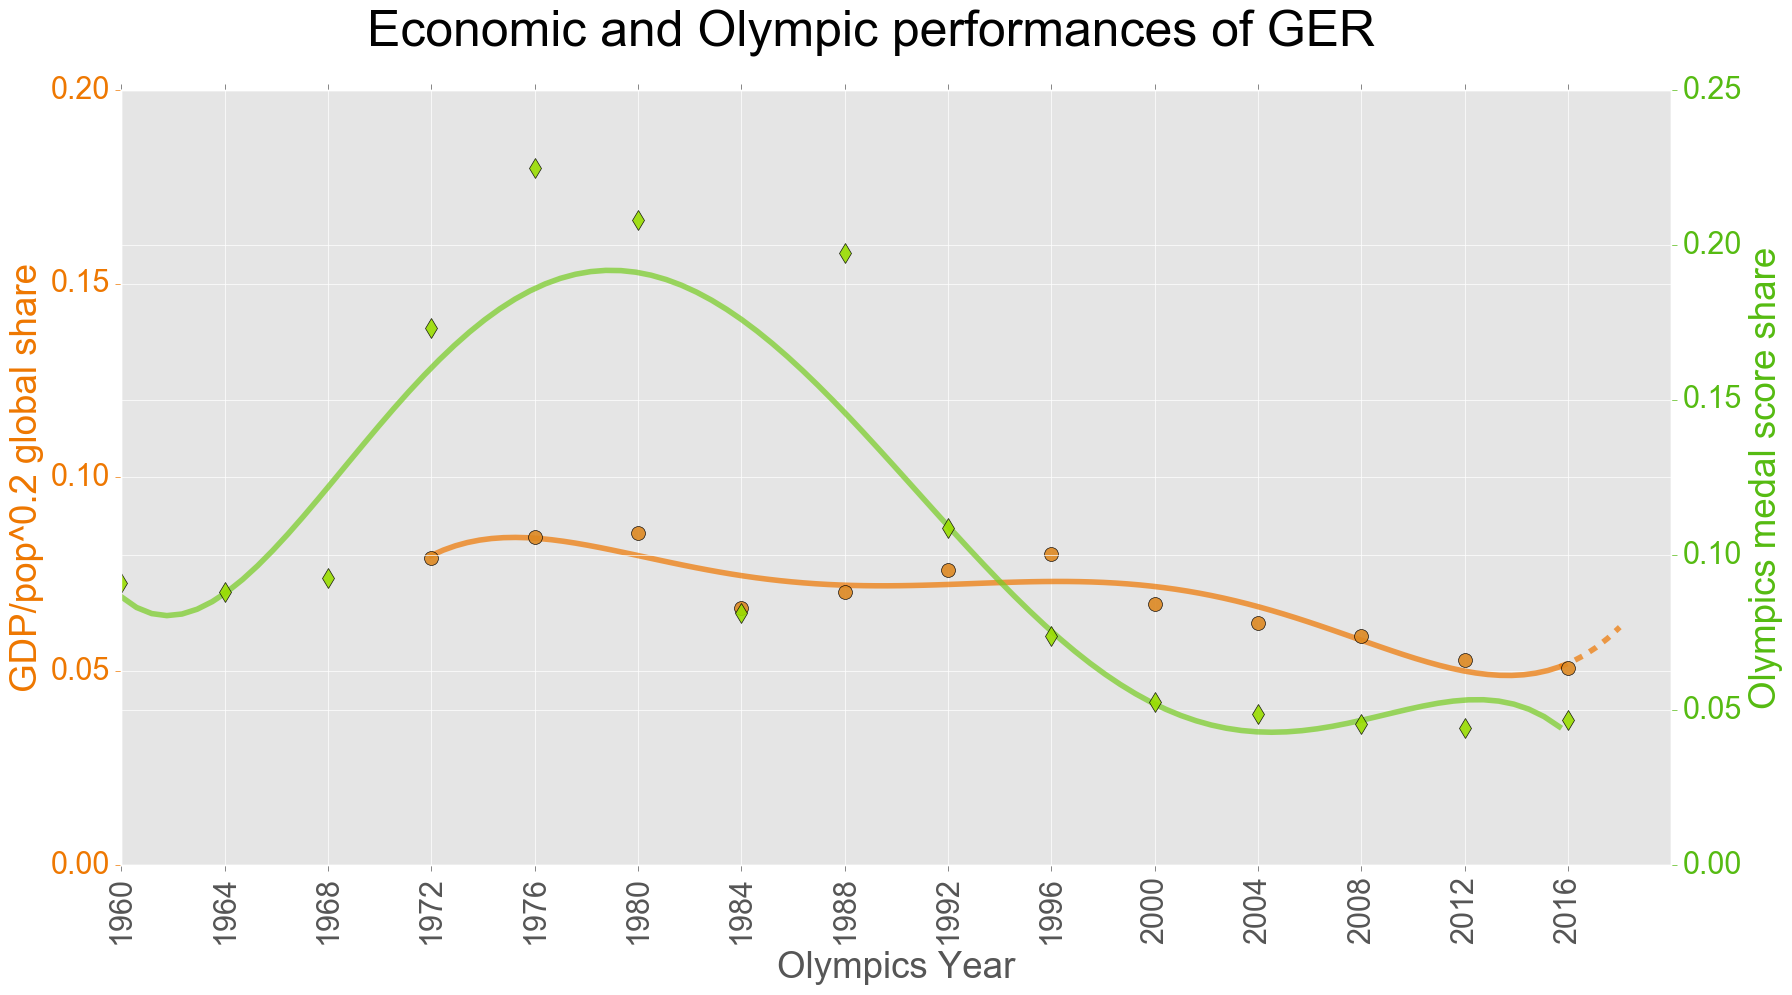

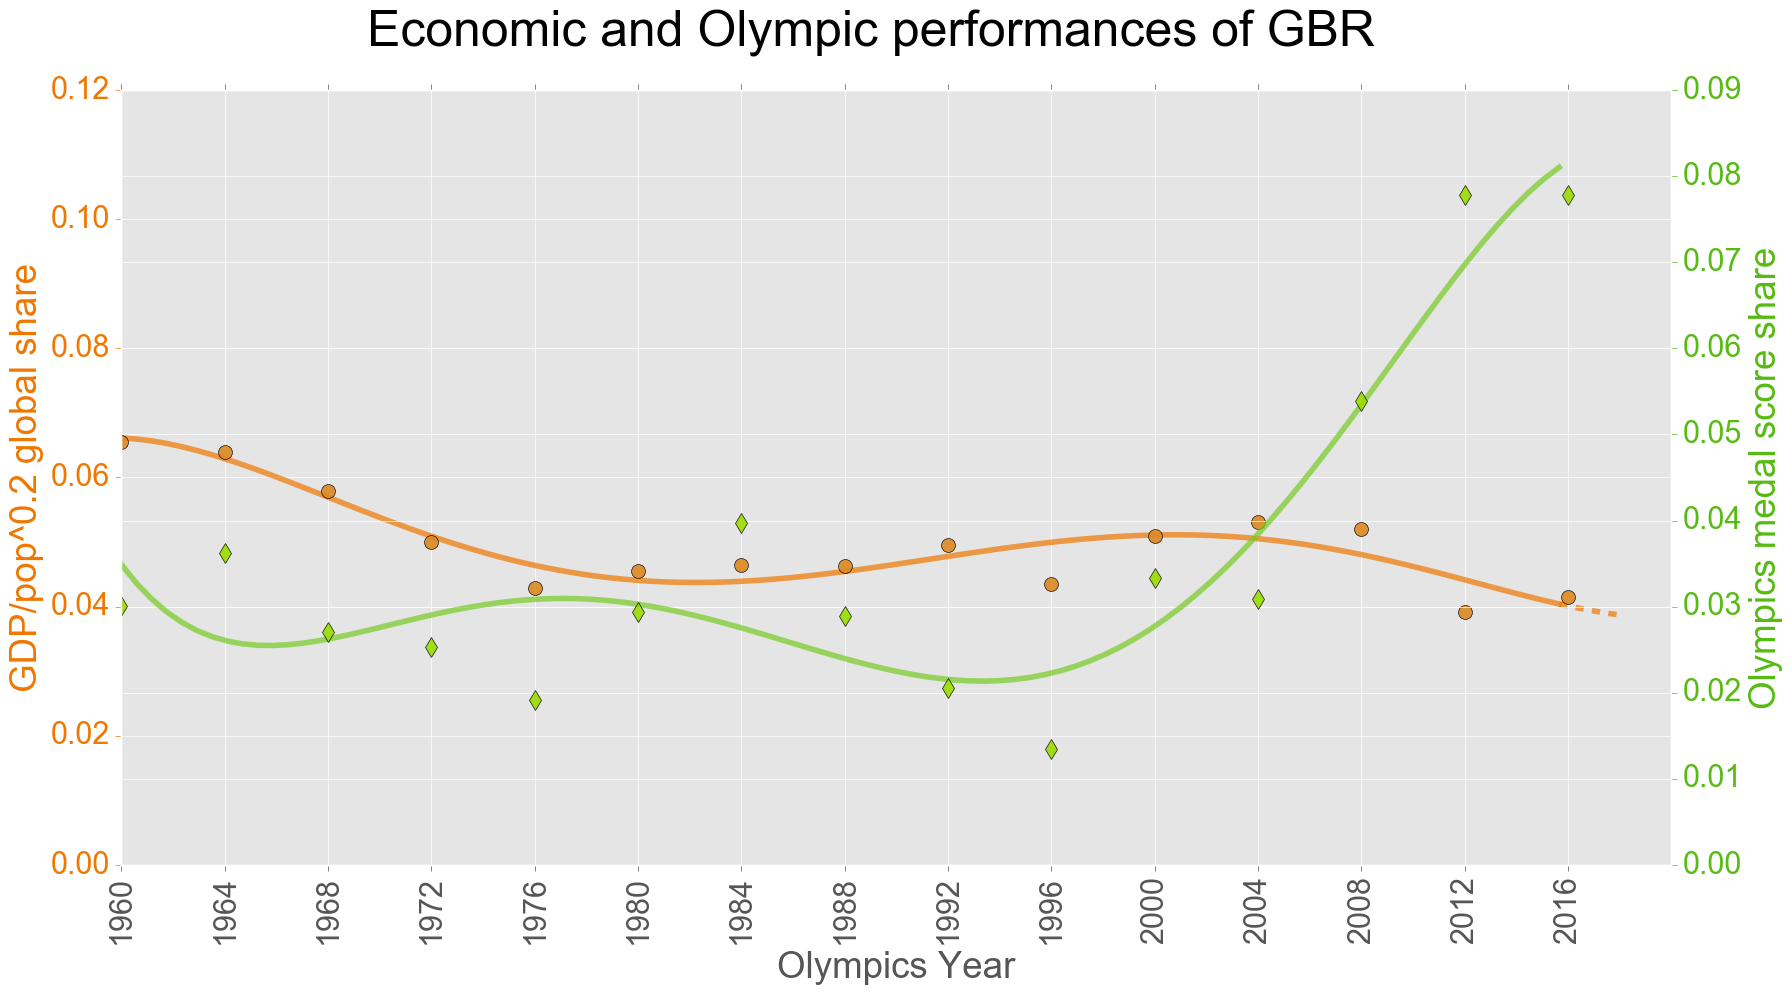

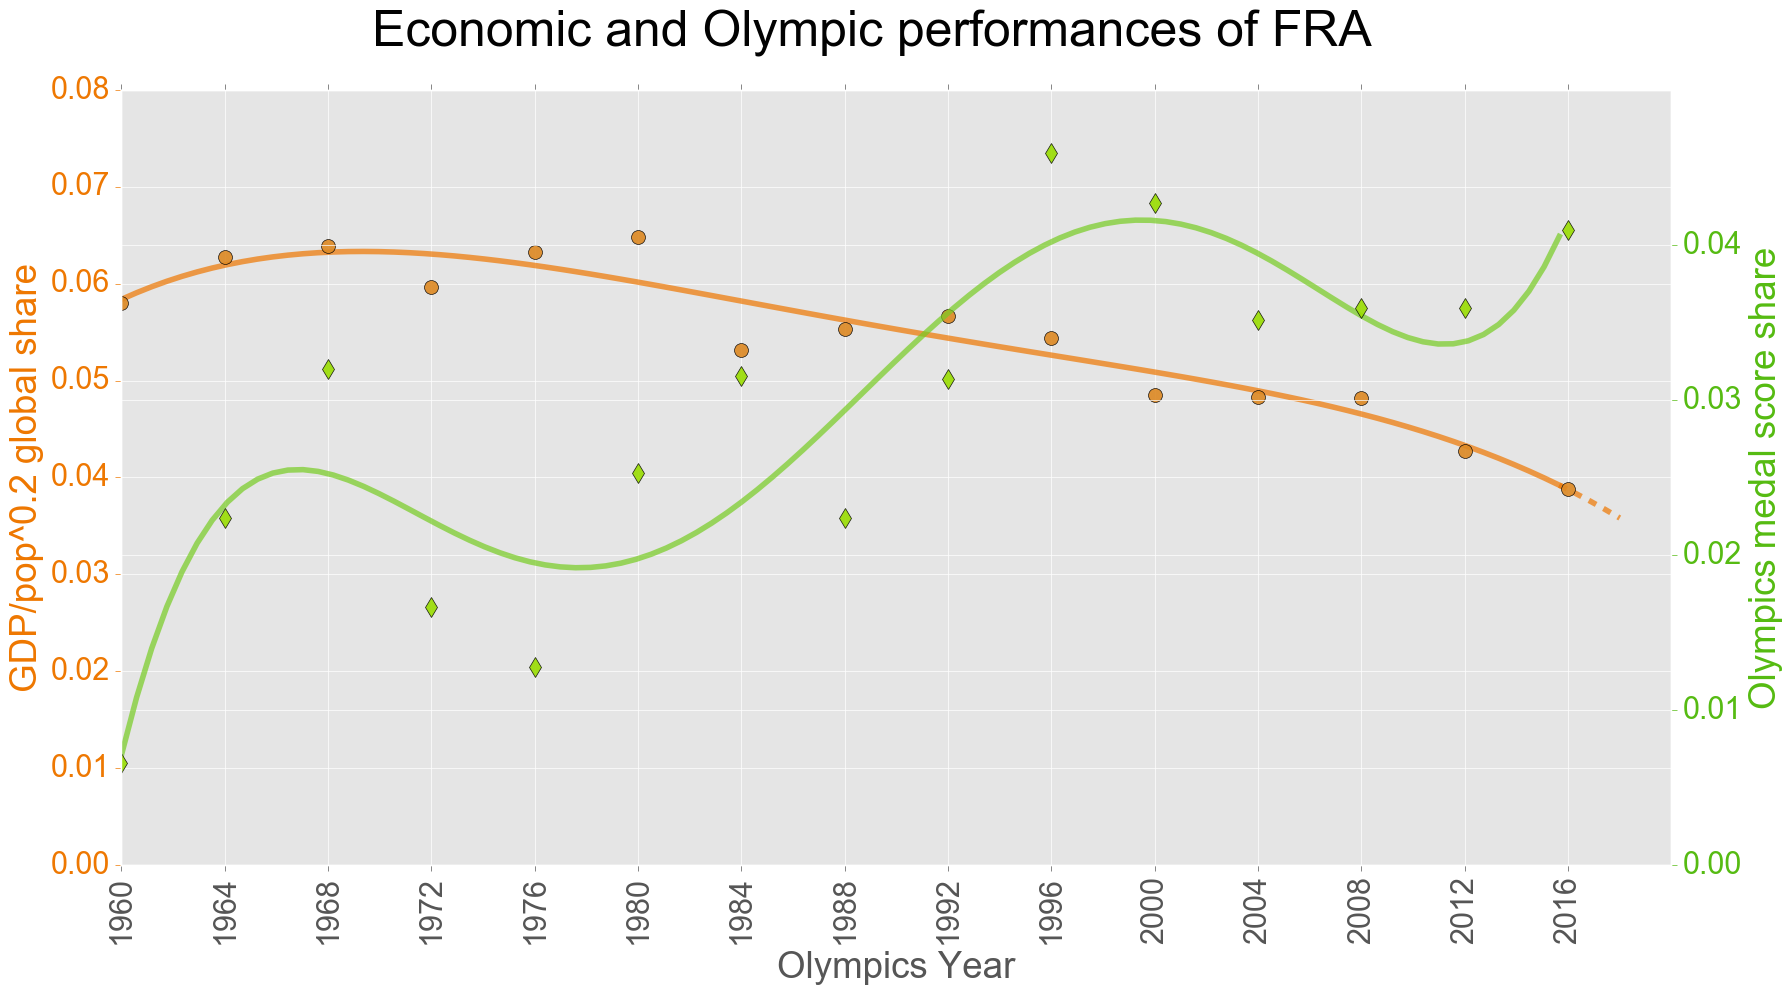

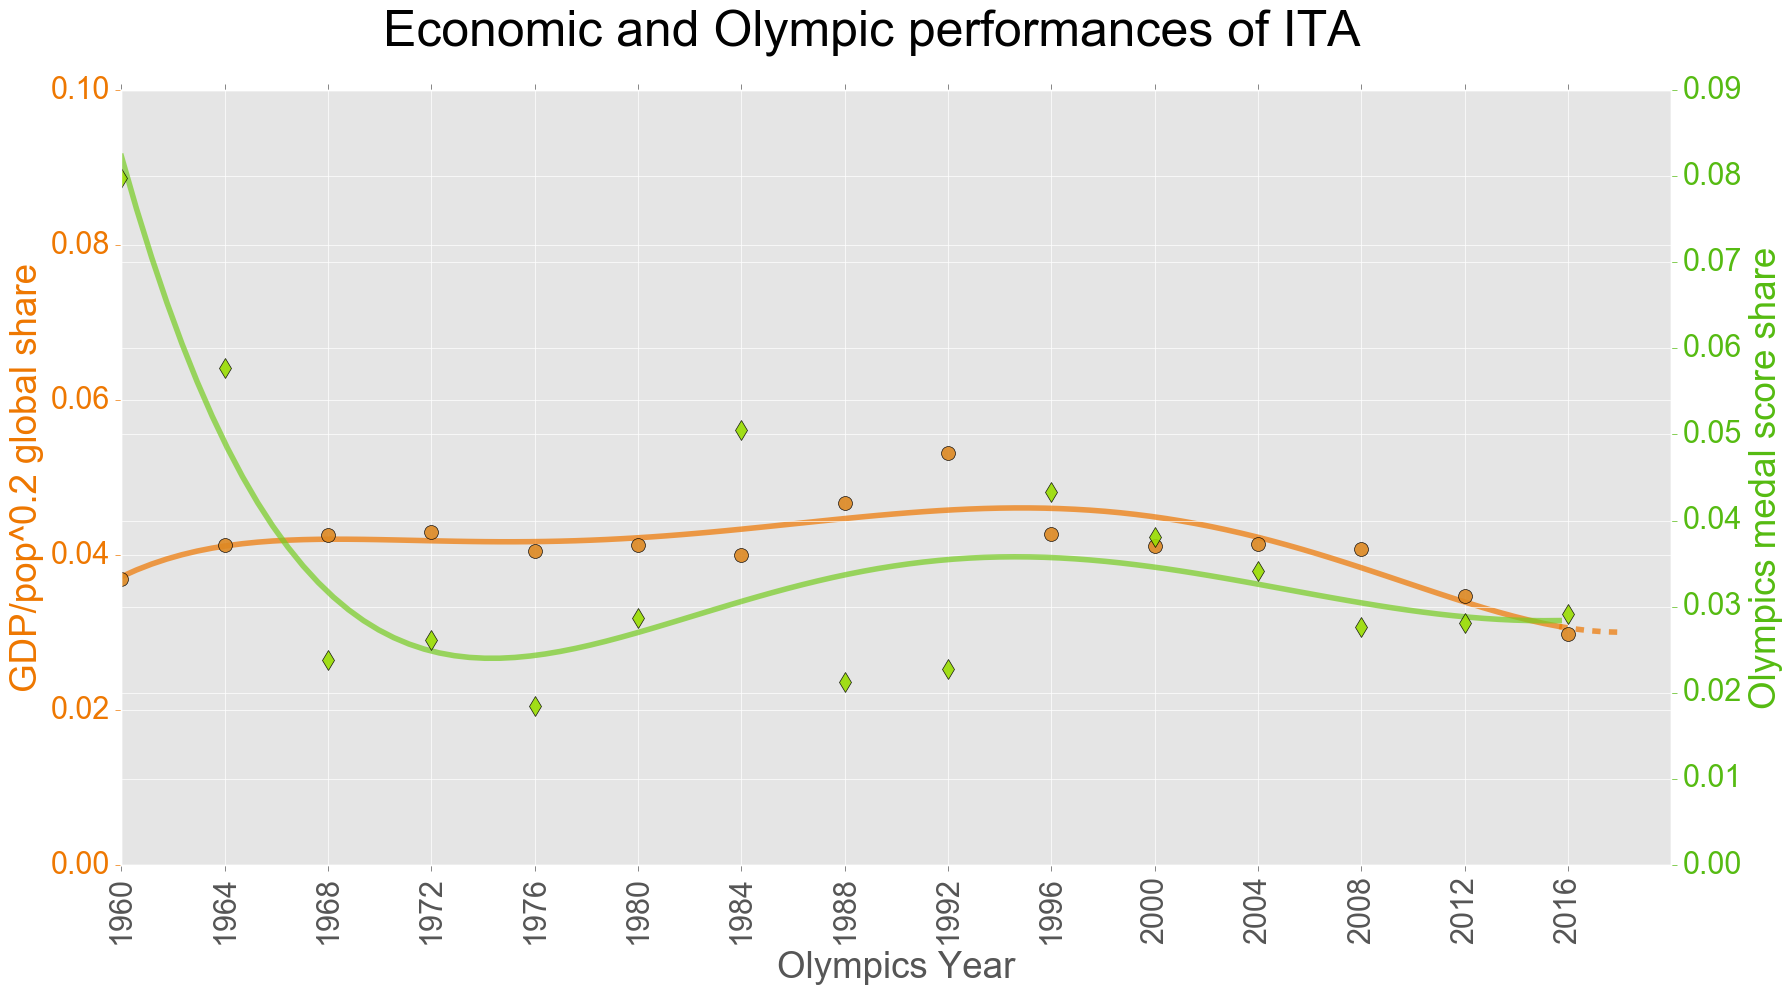

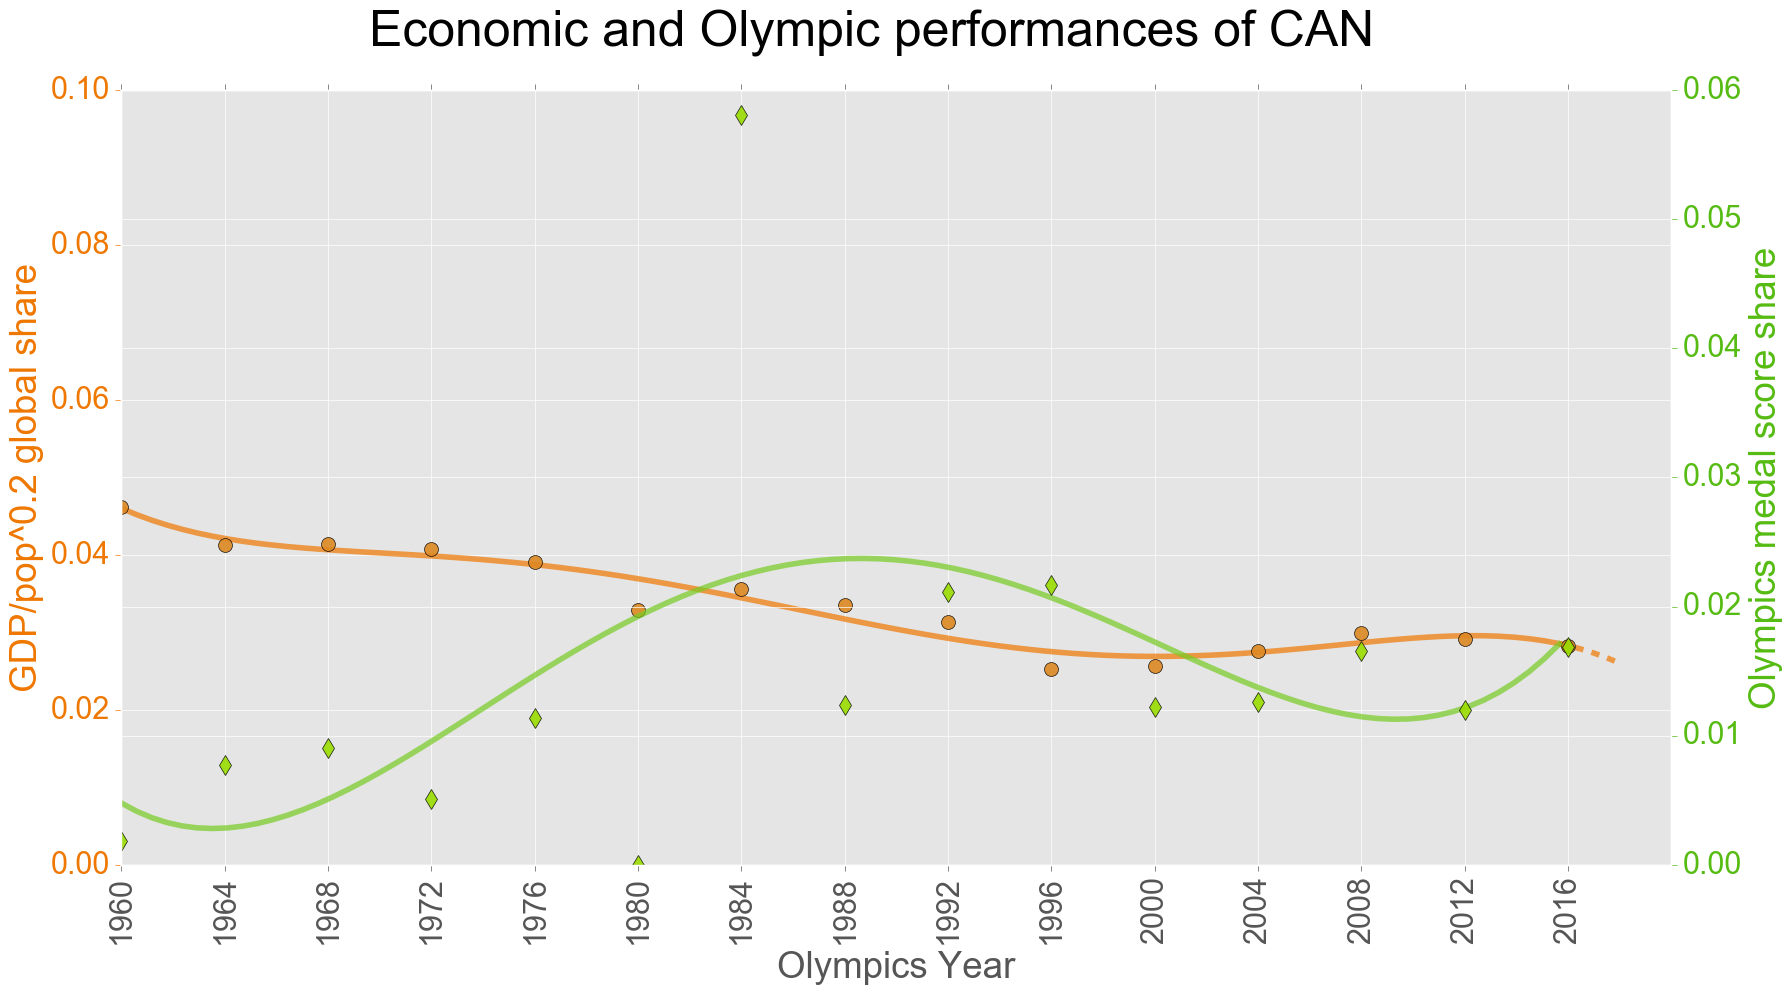

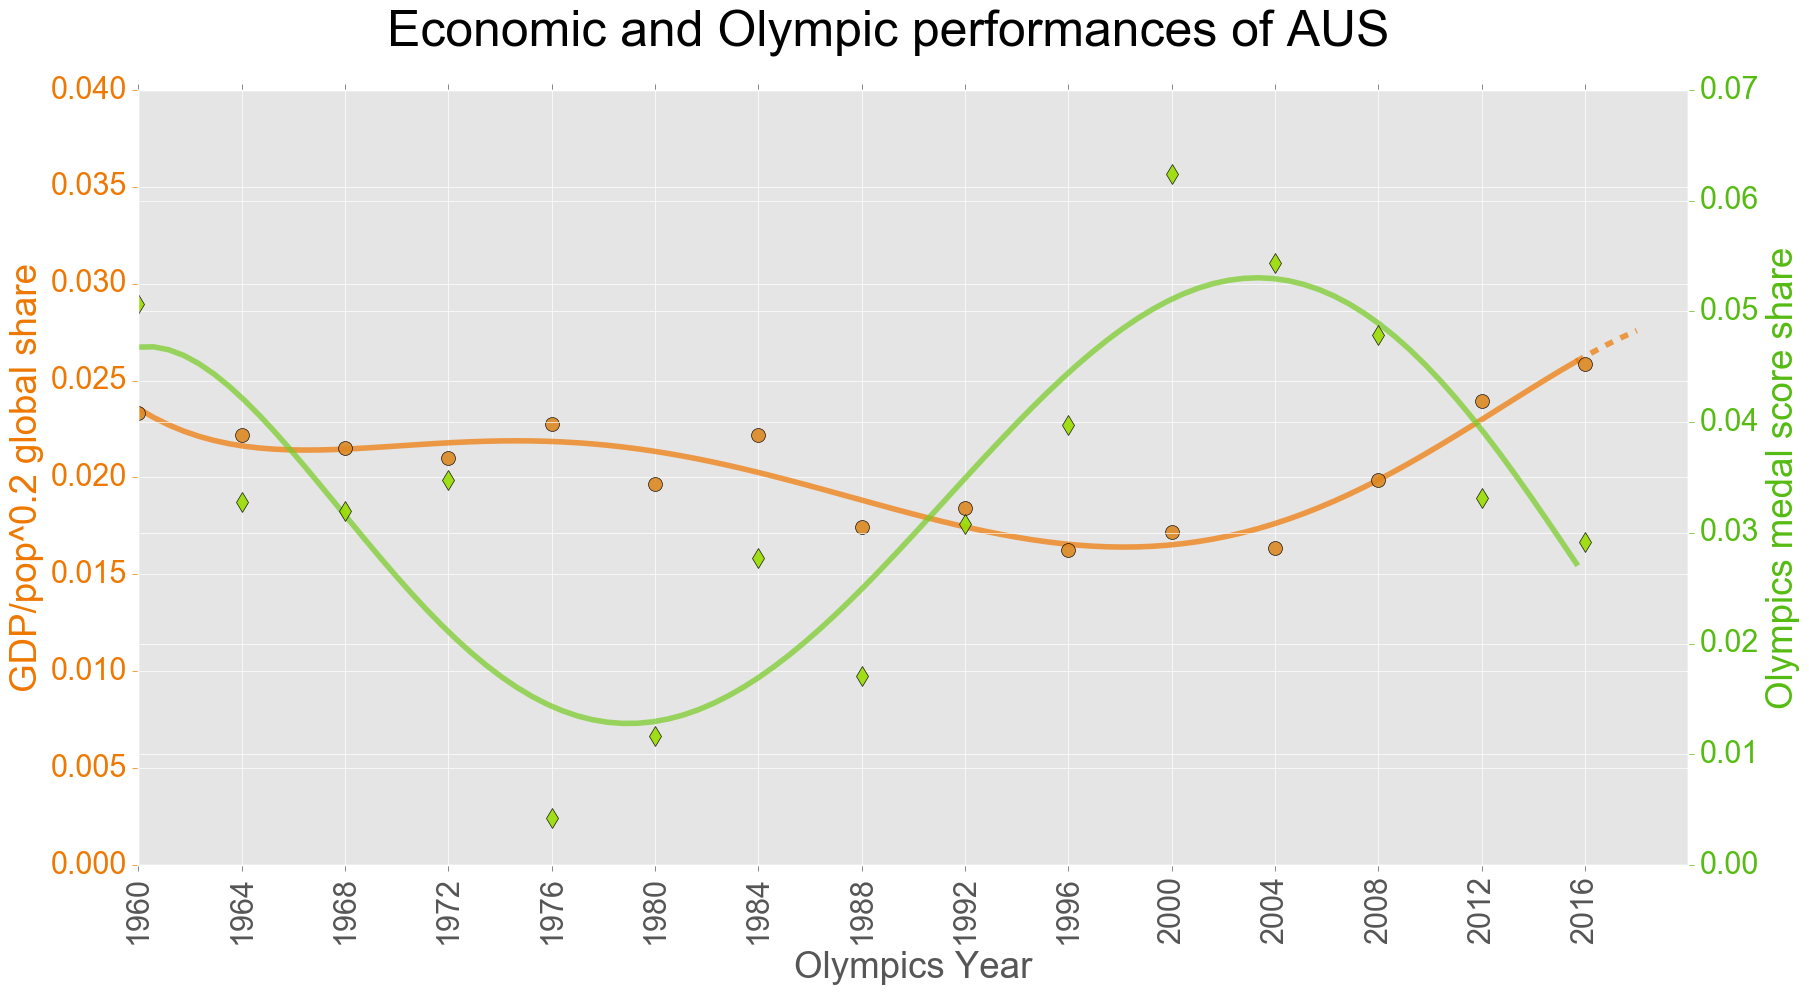

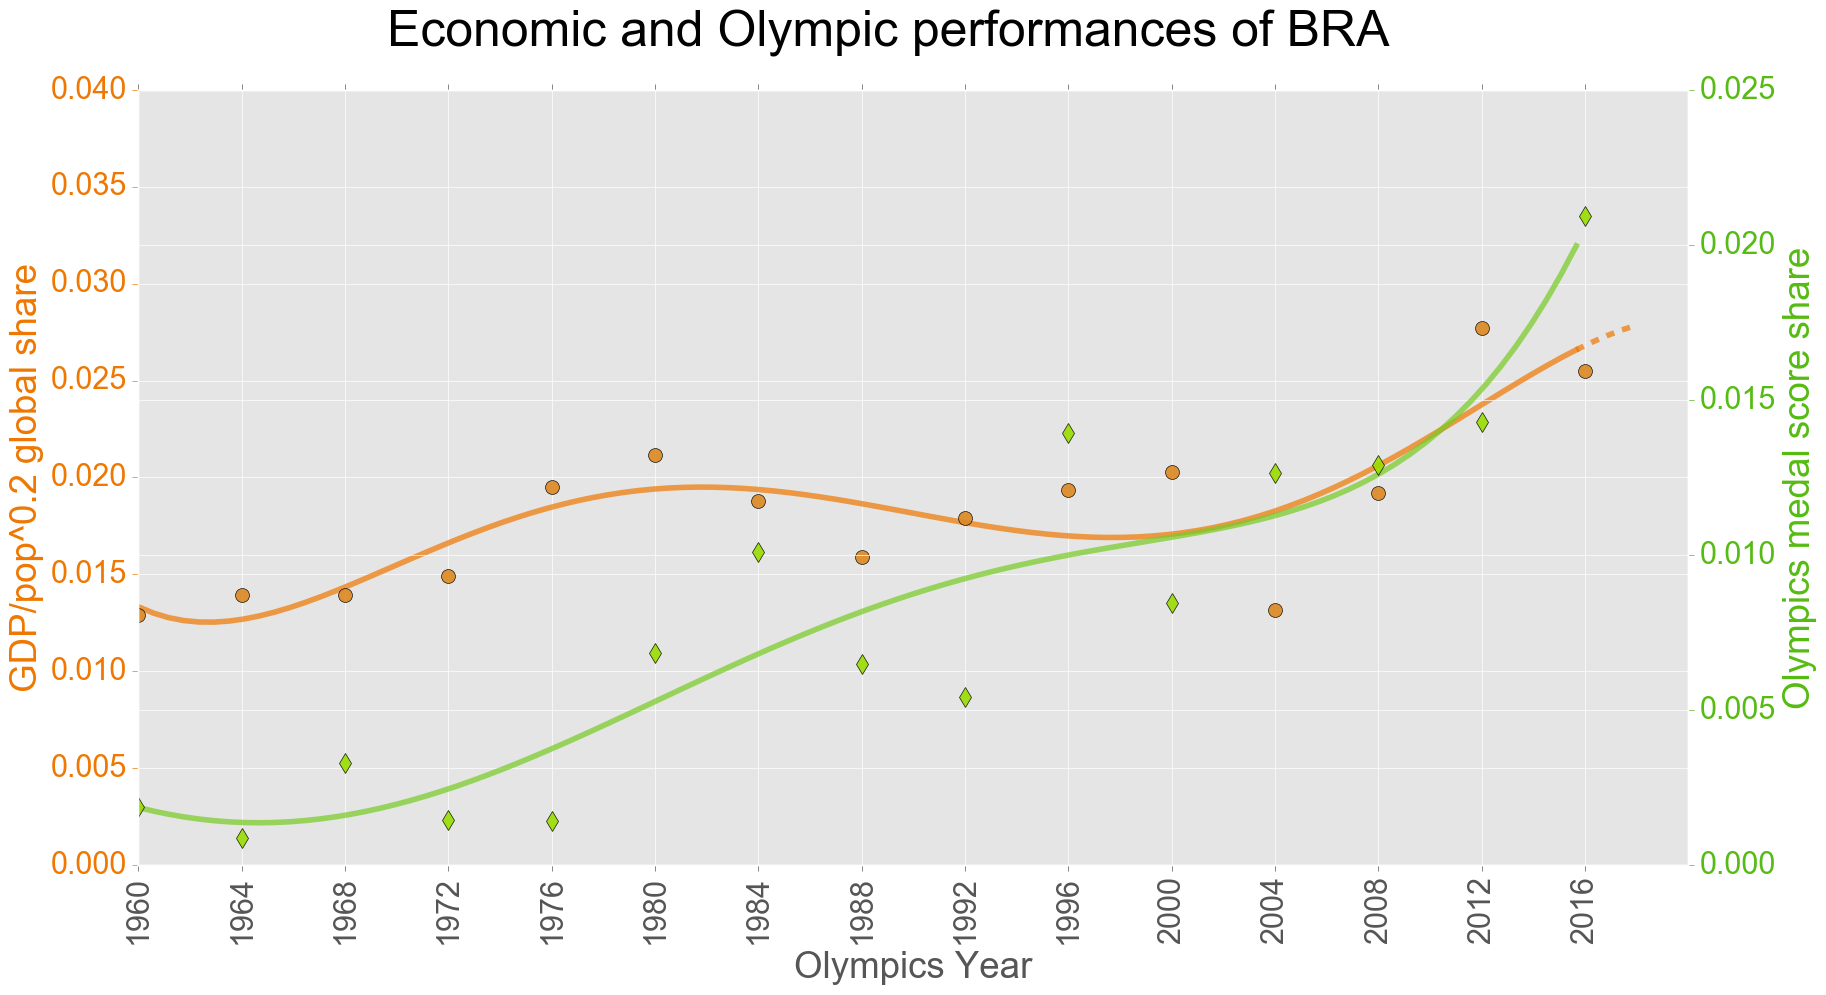

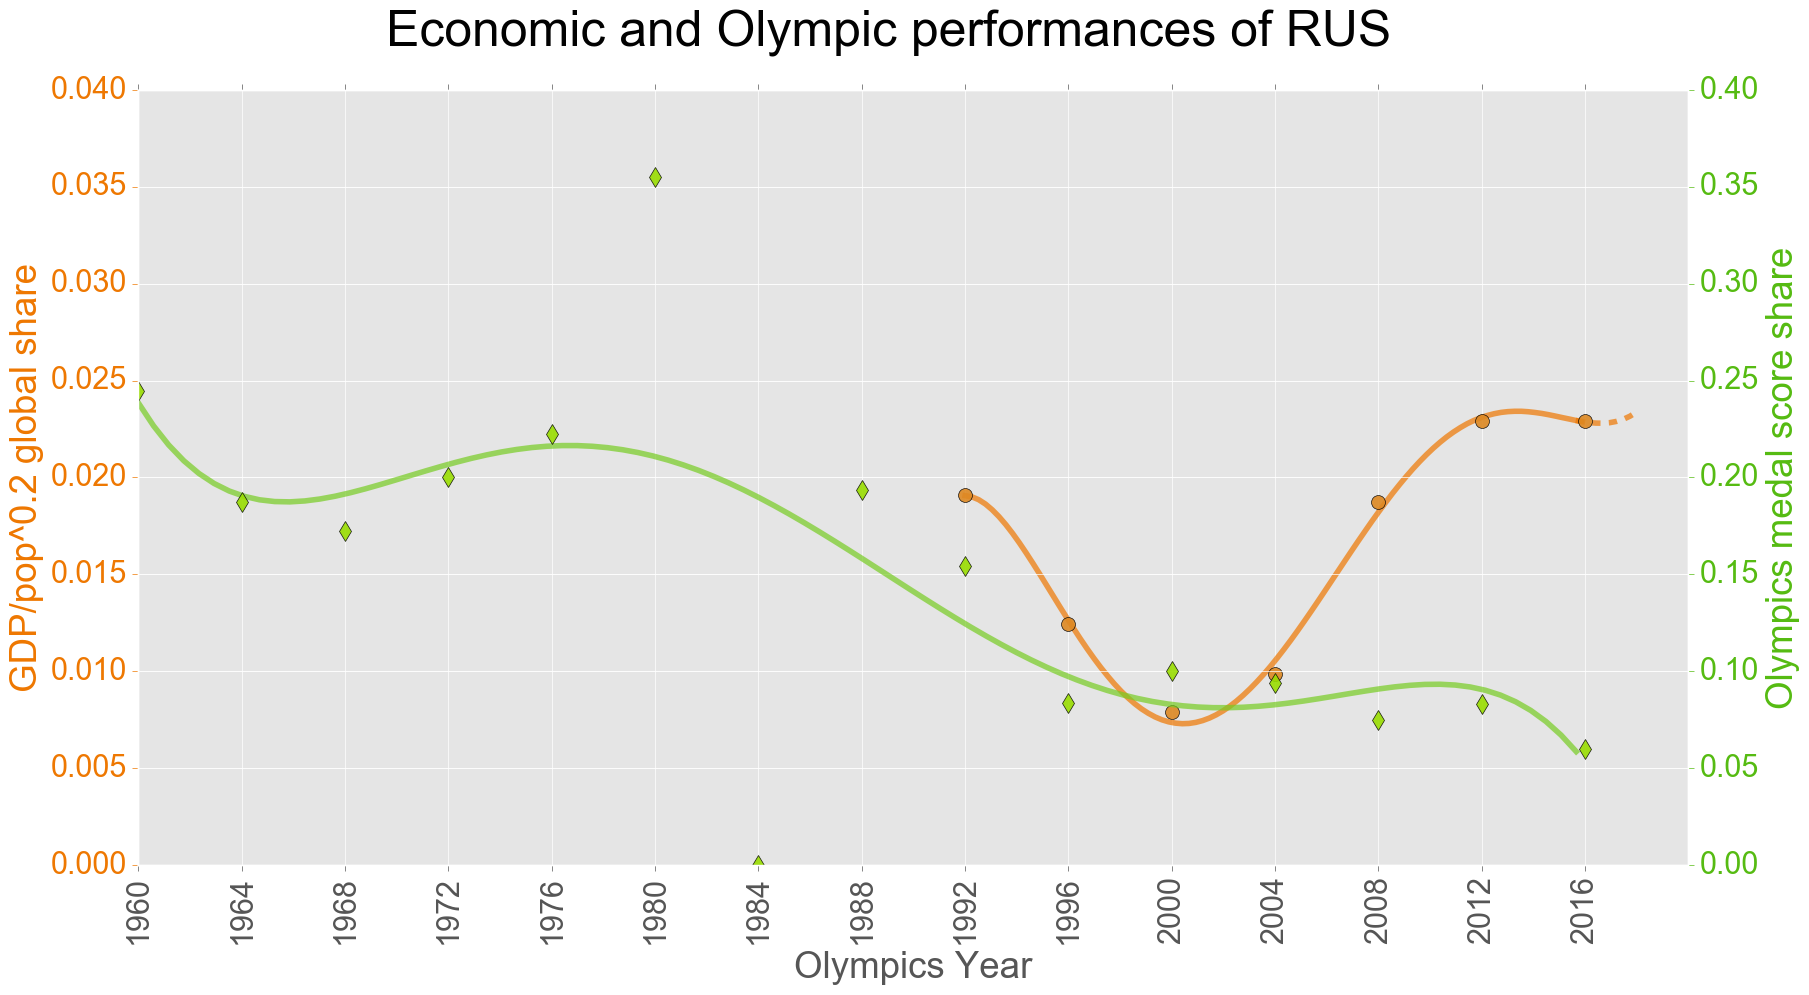

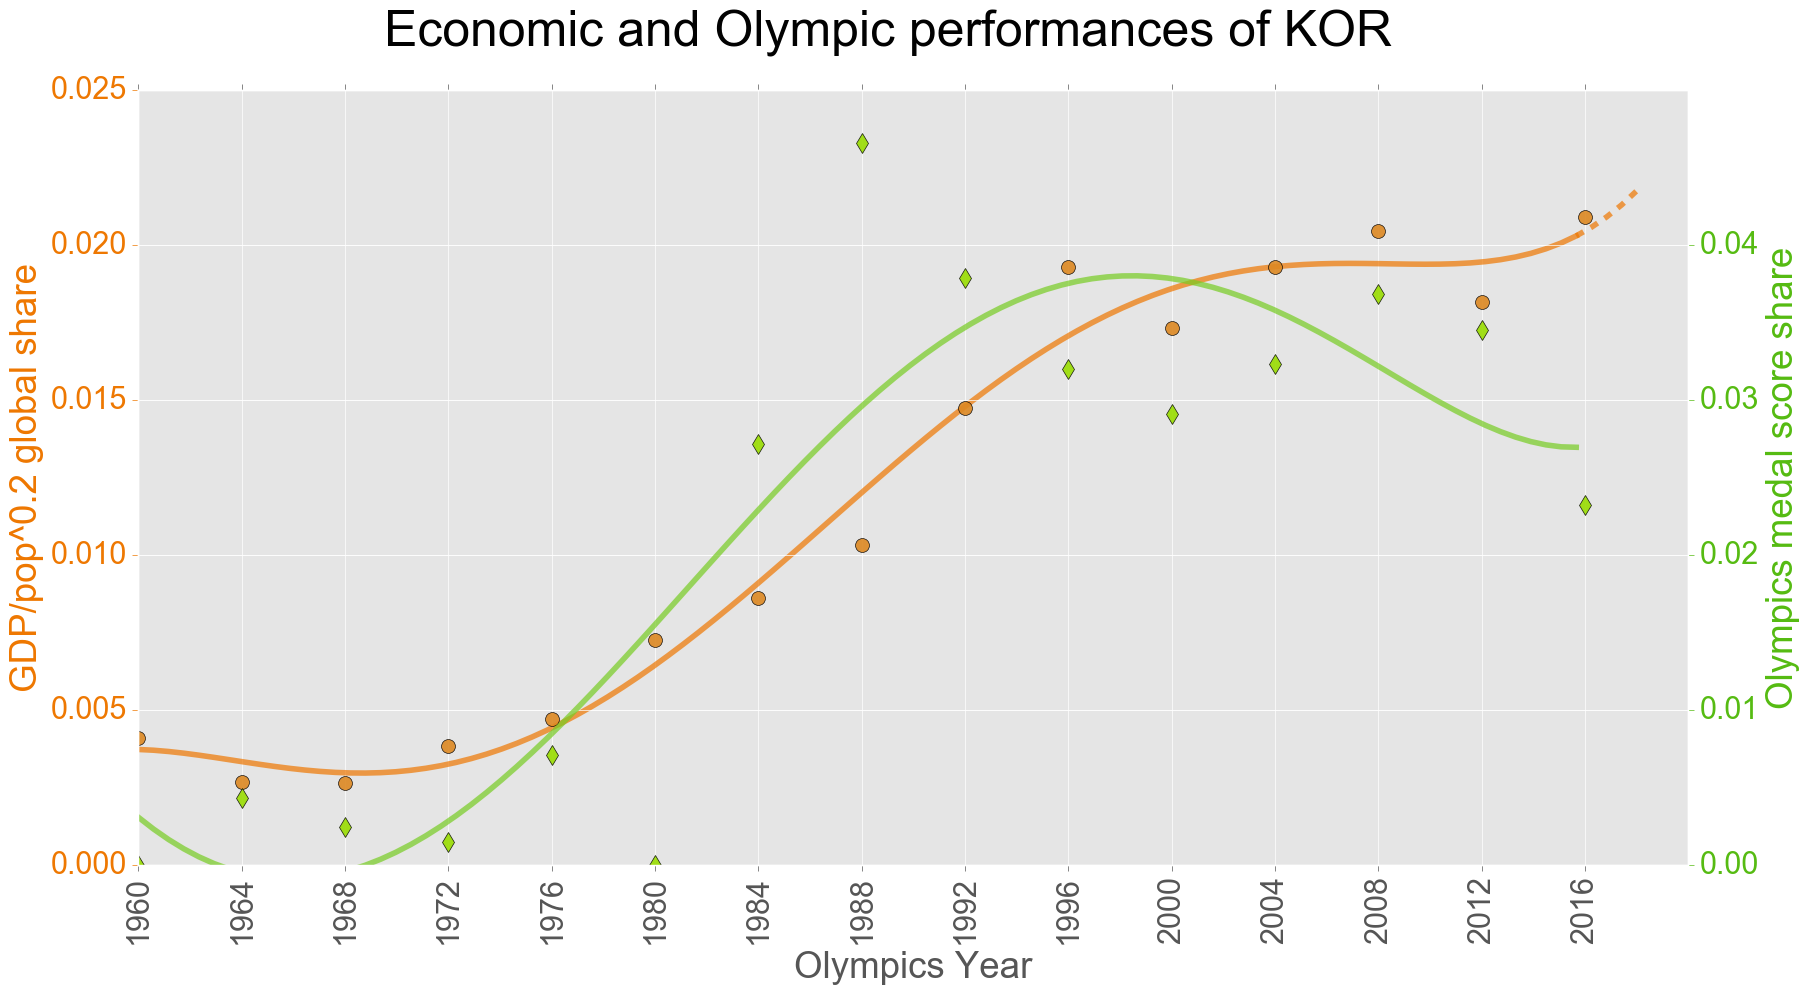

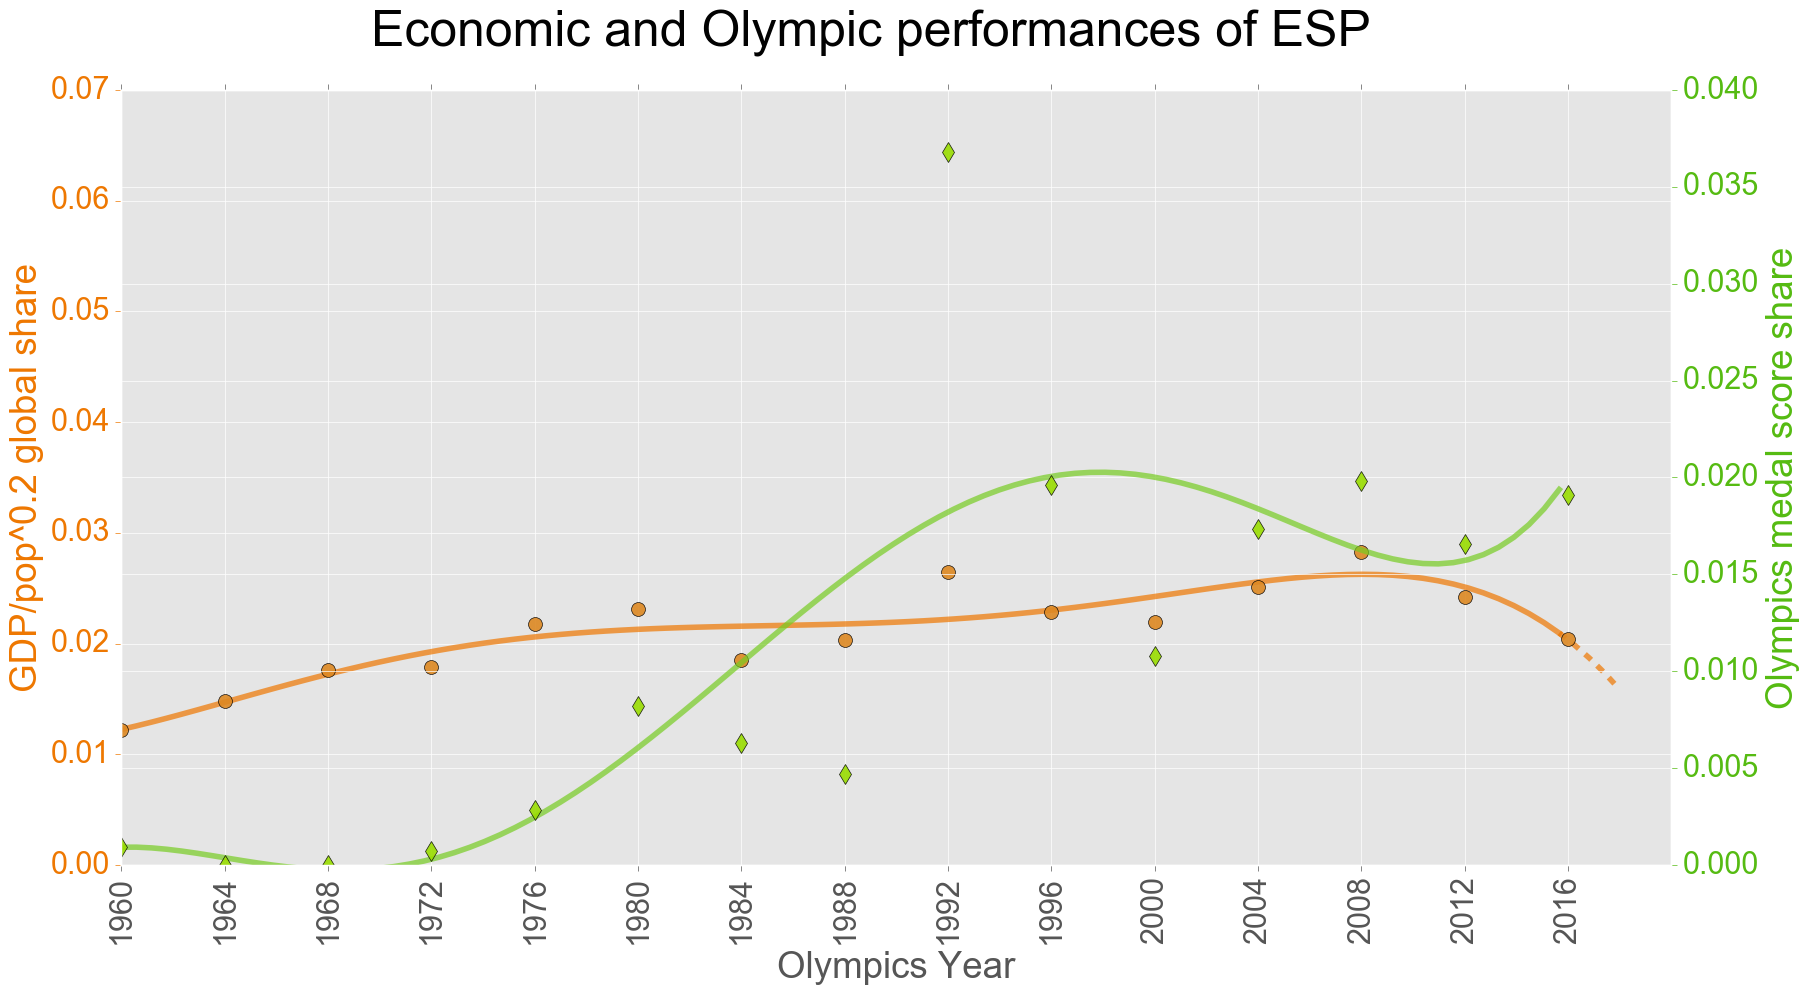

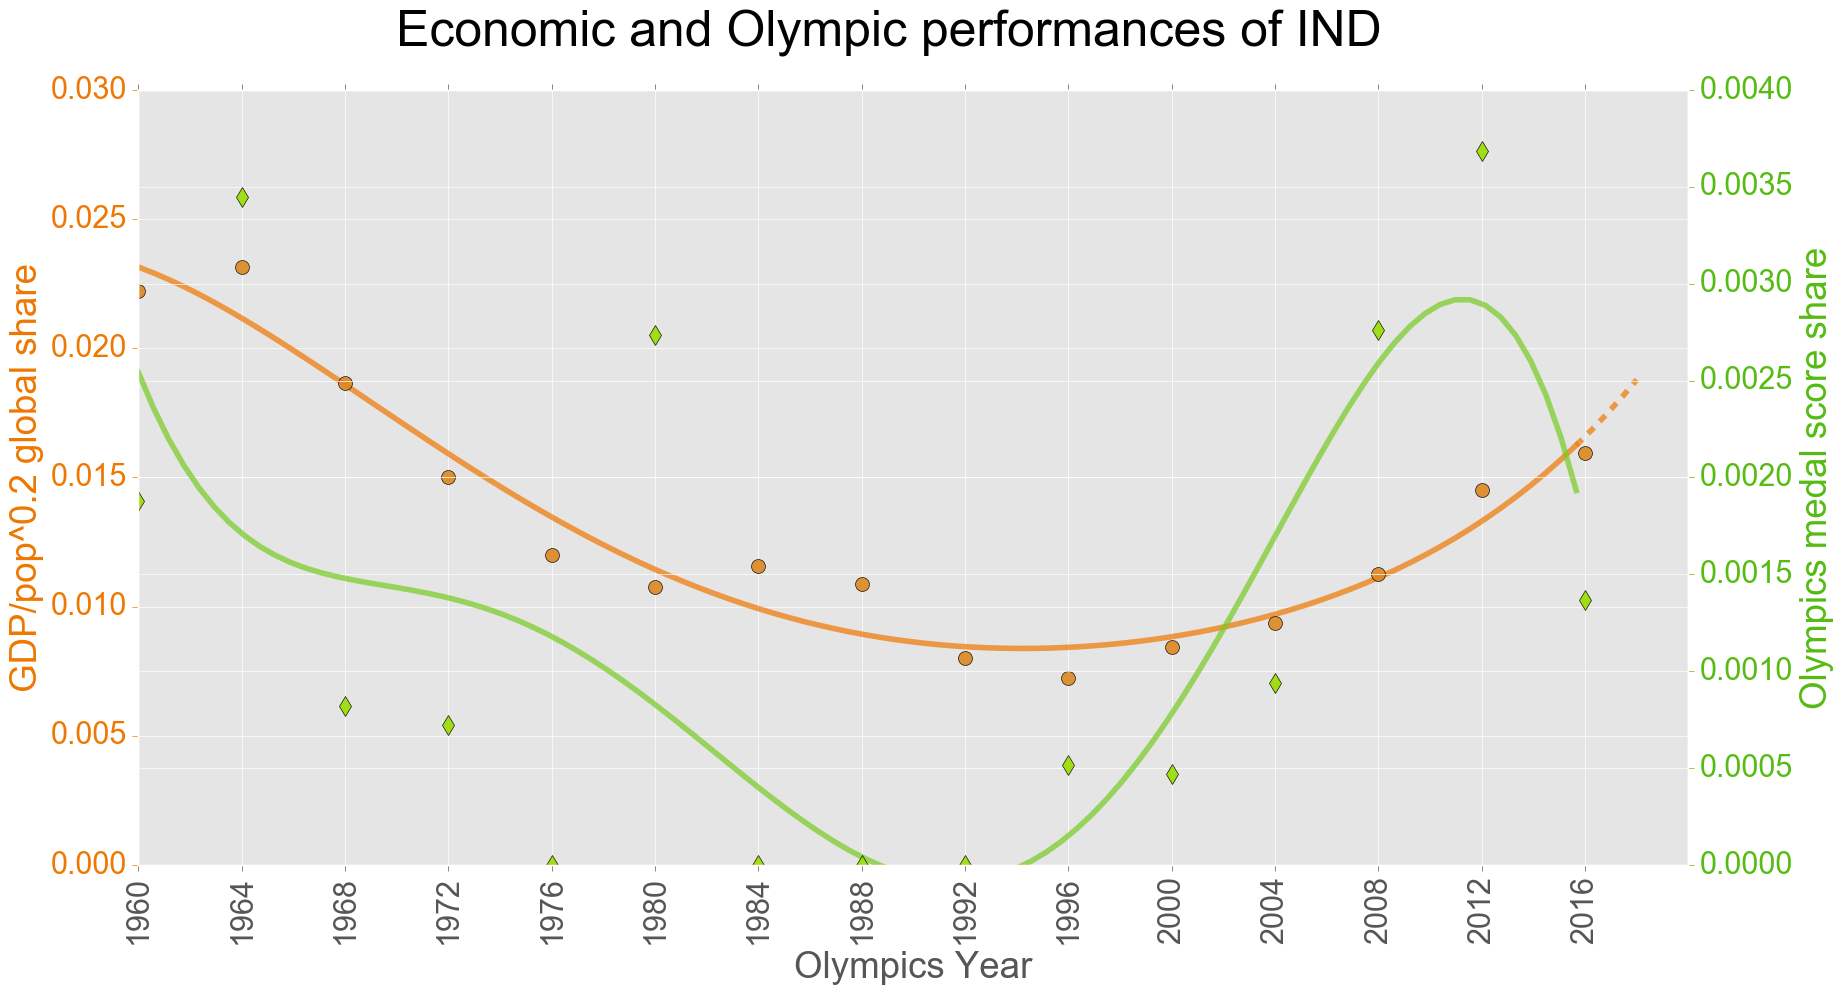

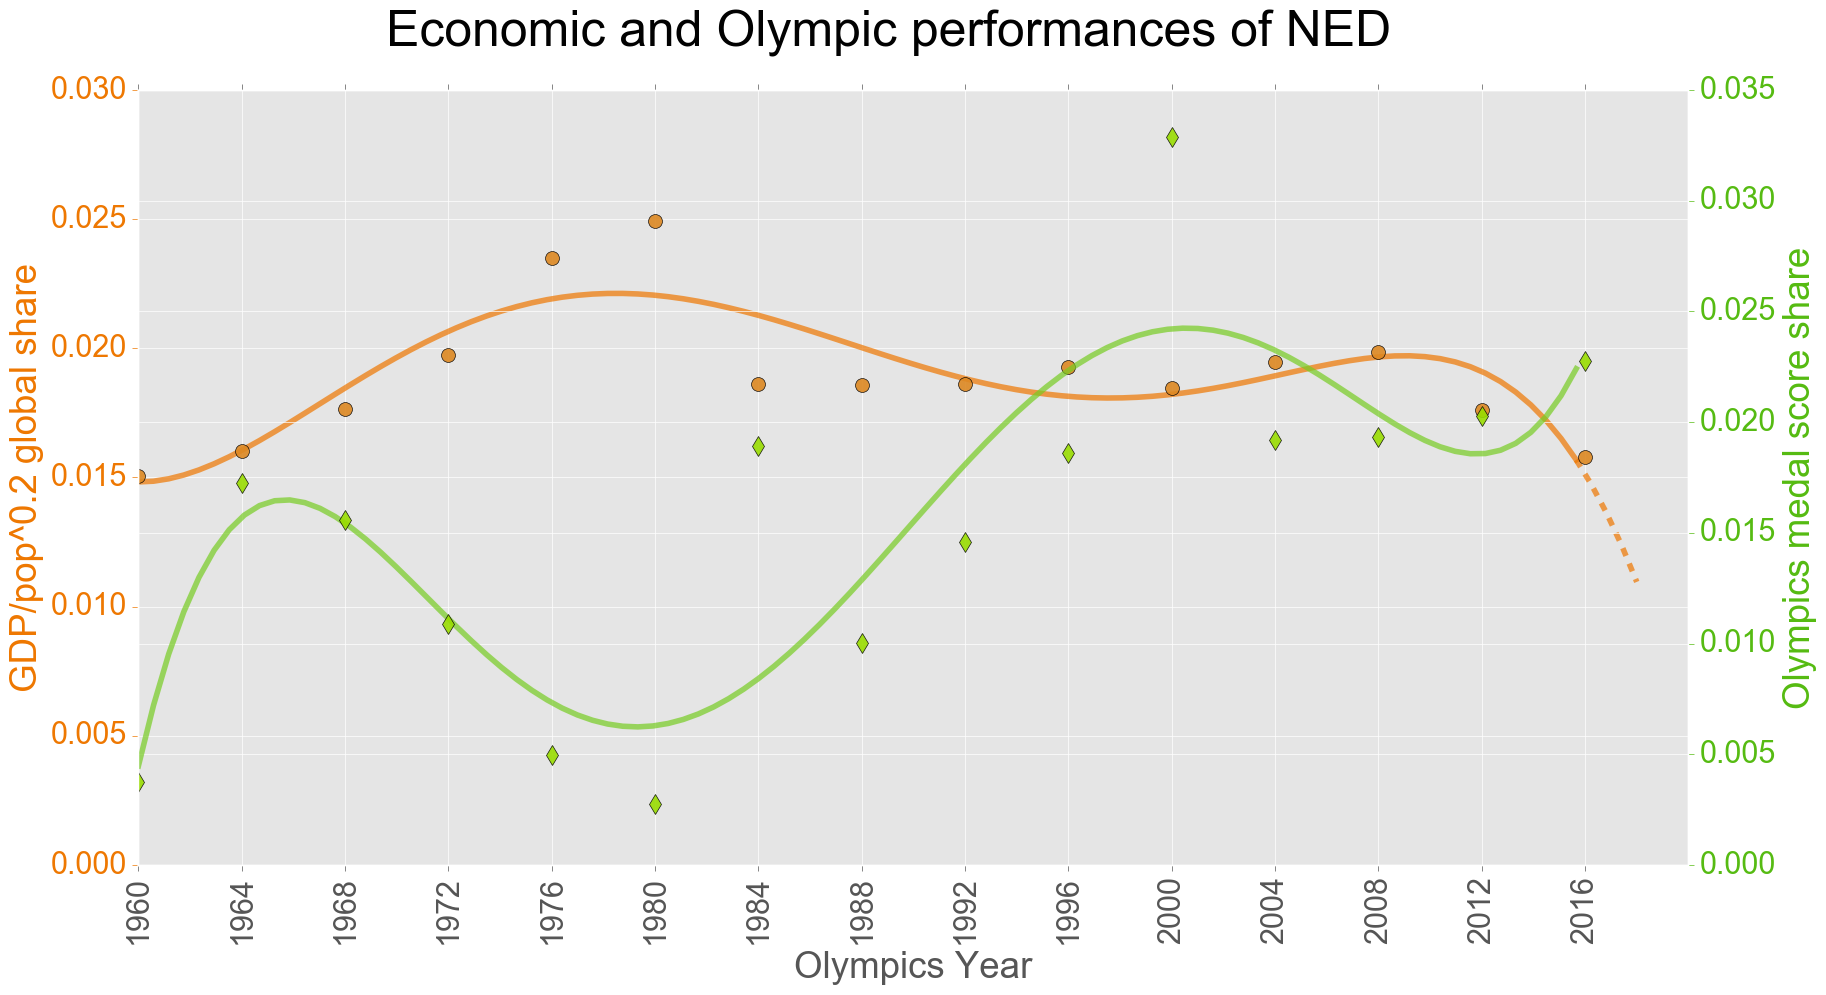

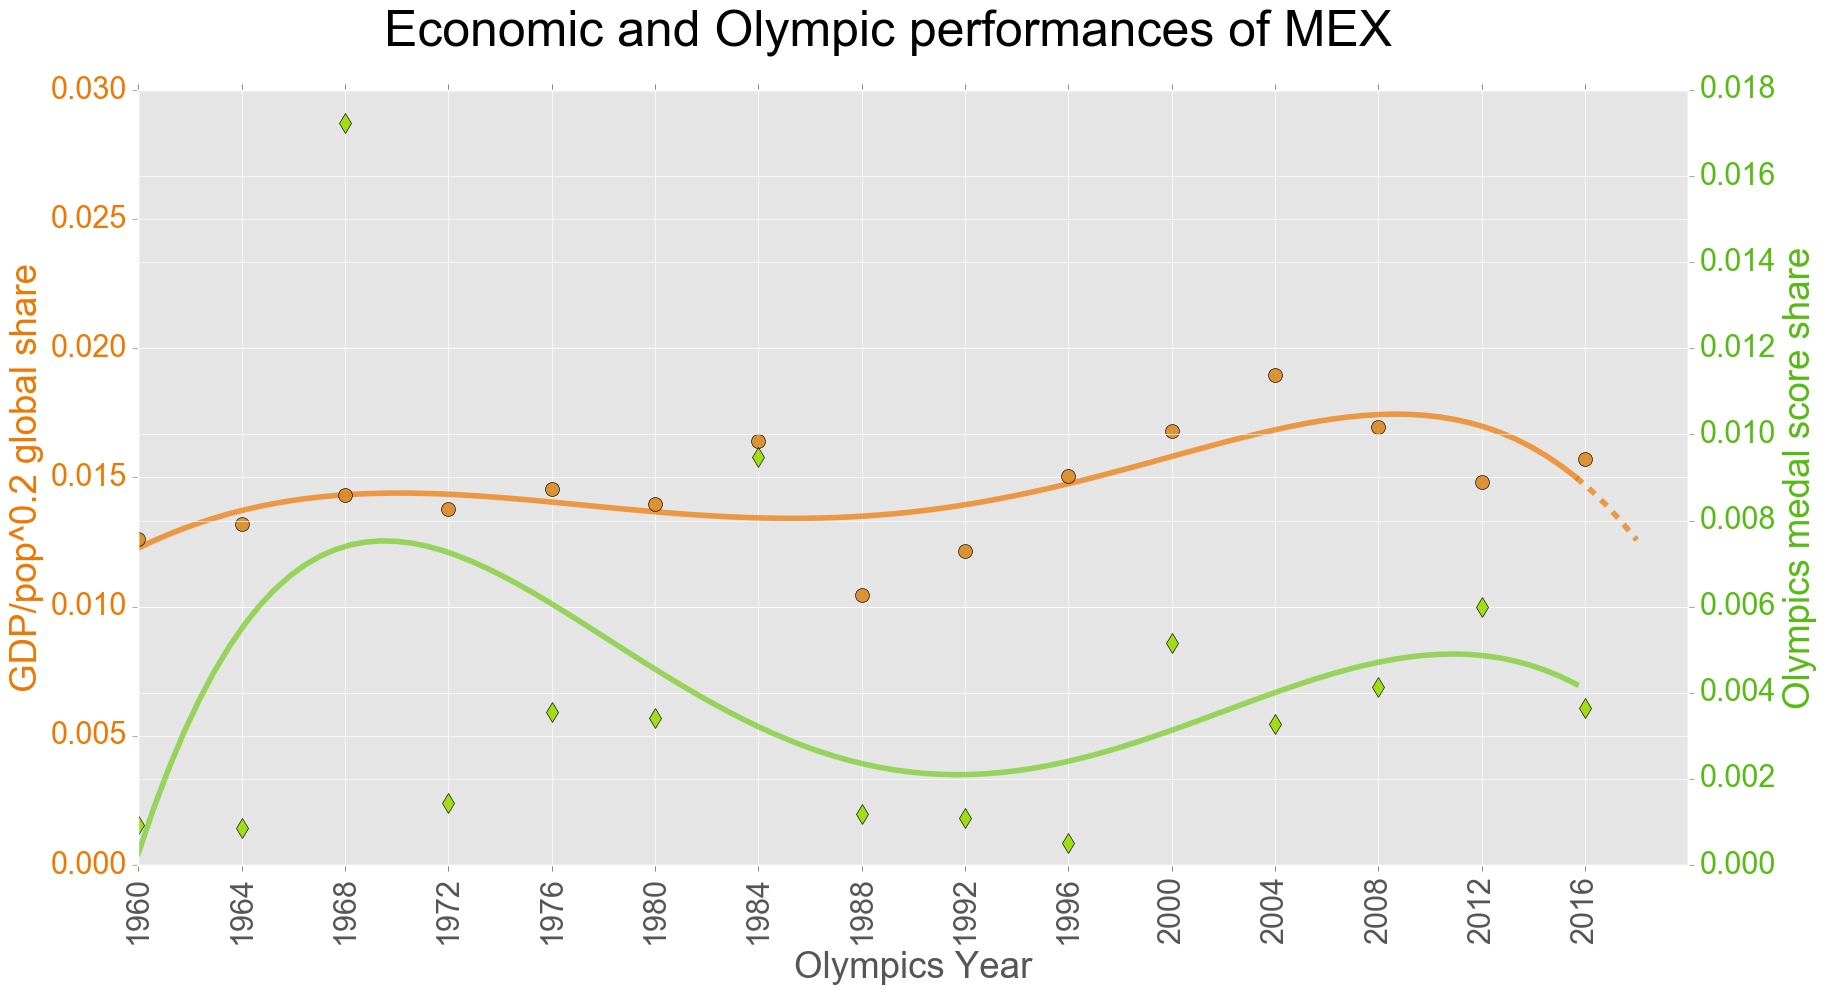

Figure 6 a-p: Diagrams showing the economy and Olympics performance trends of the top-economy
nations revealing strong correlations of the two metrics used for most of these countries.


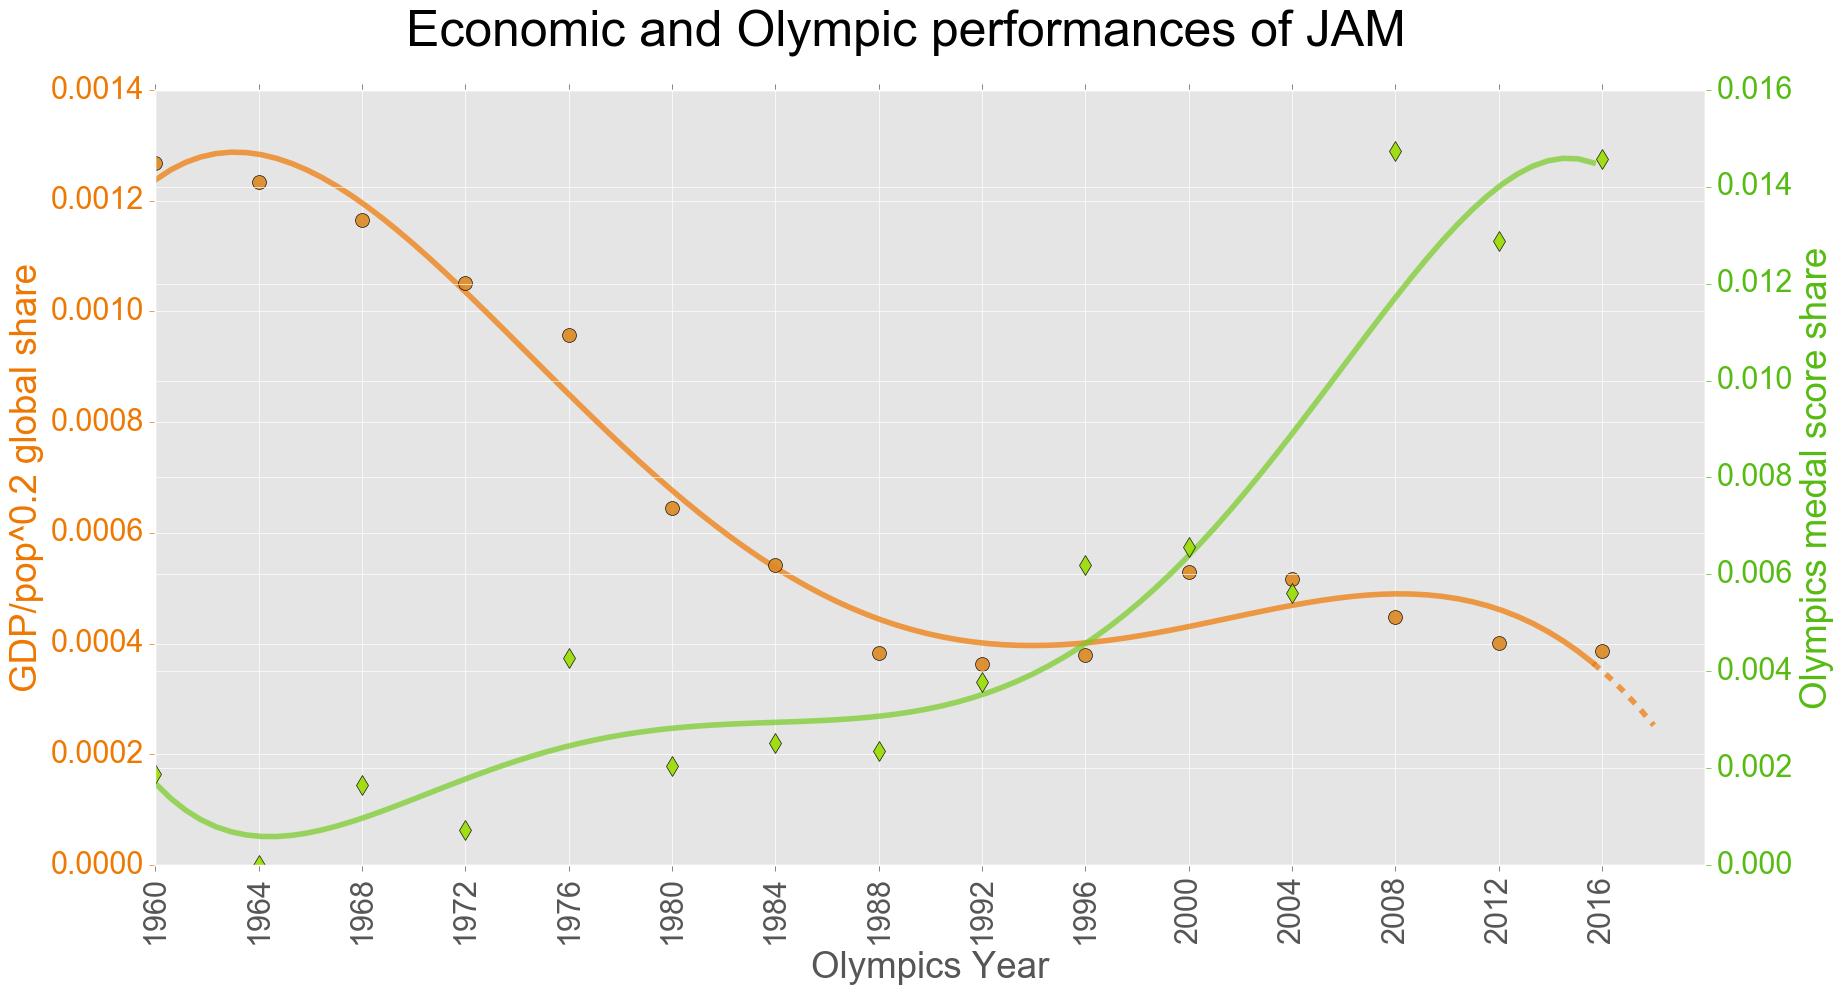

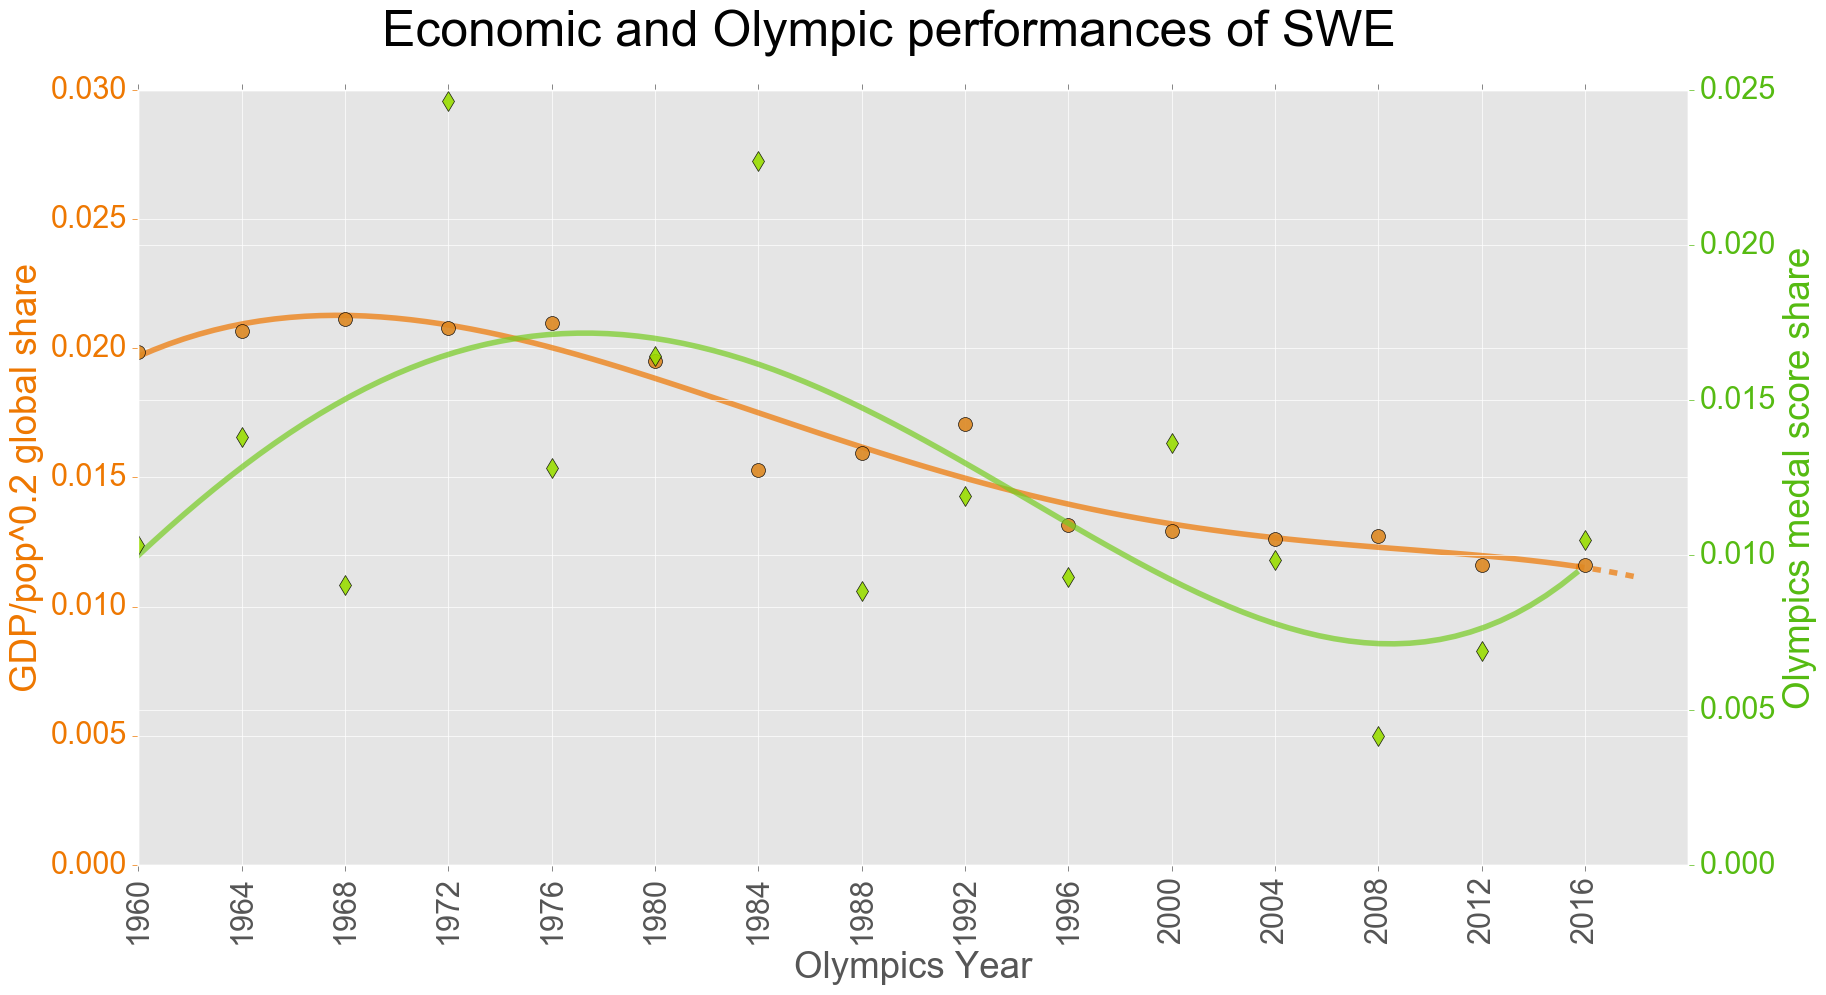

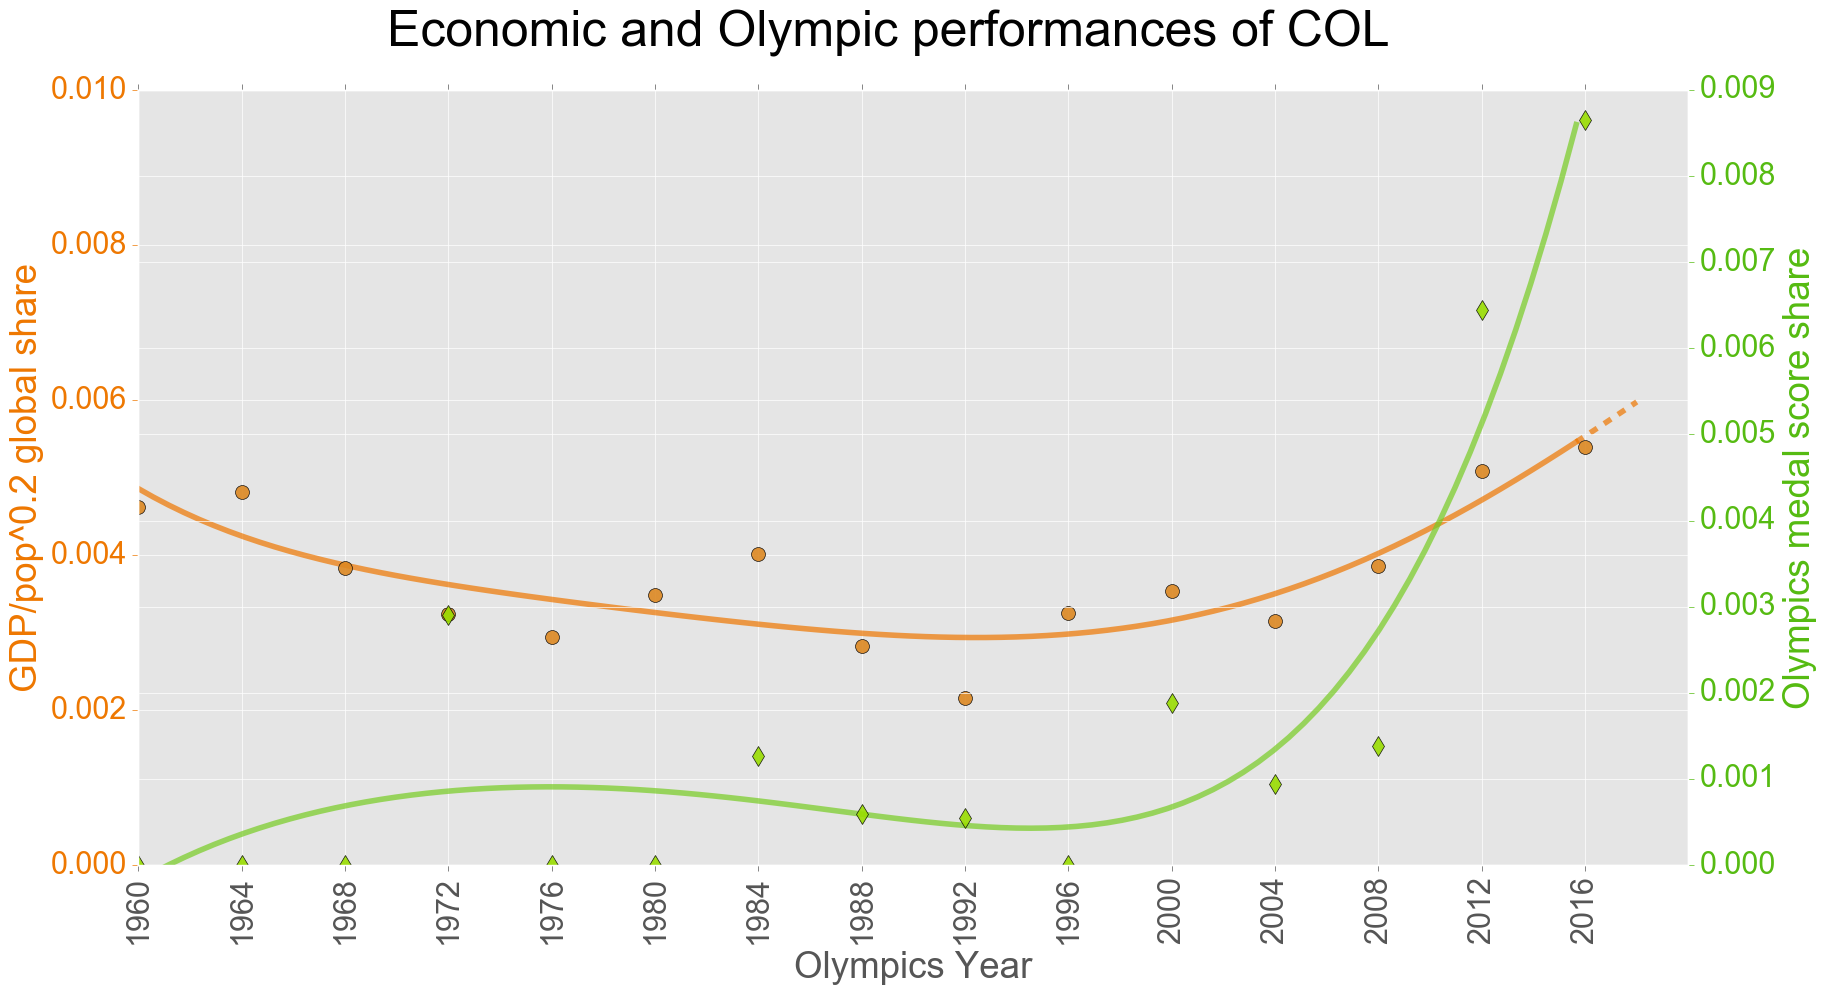

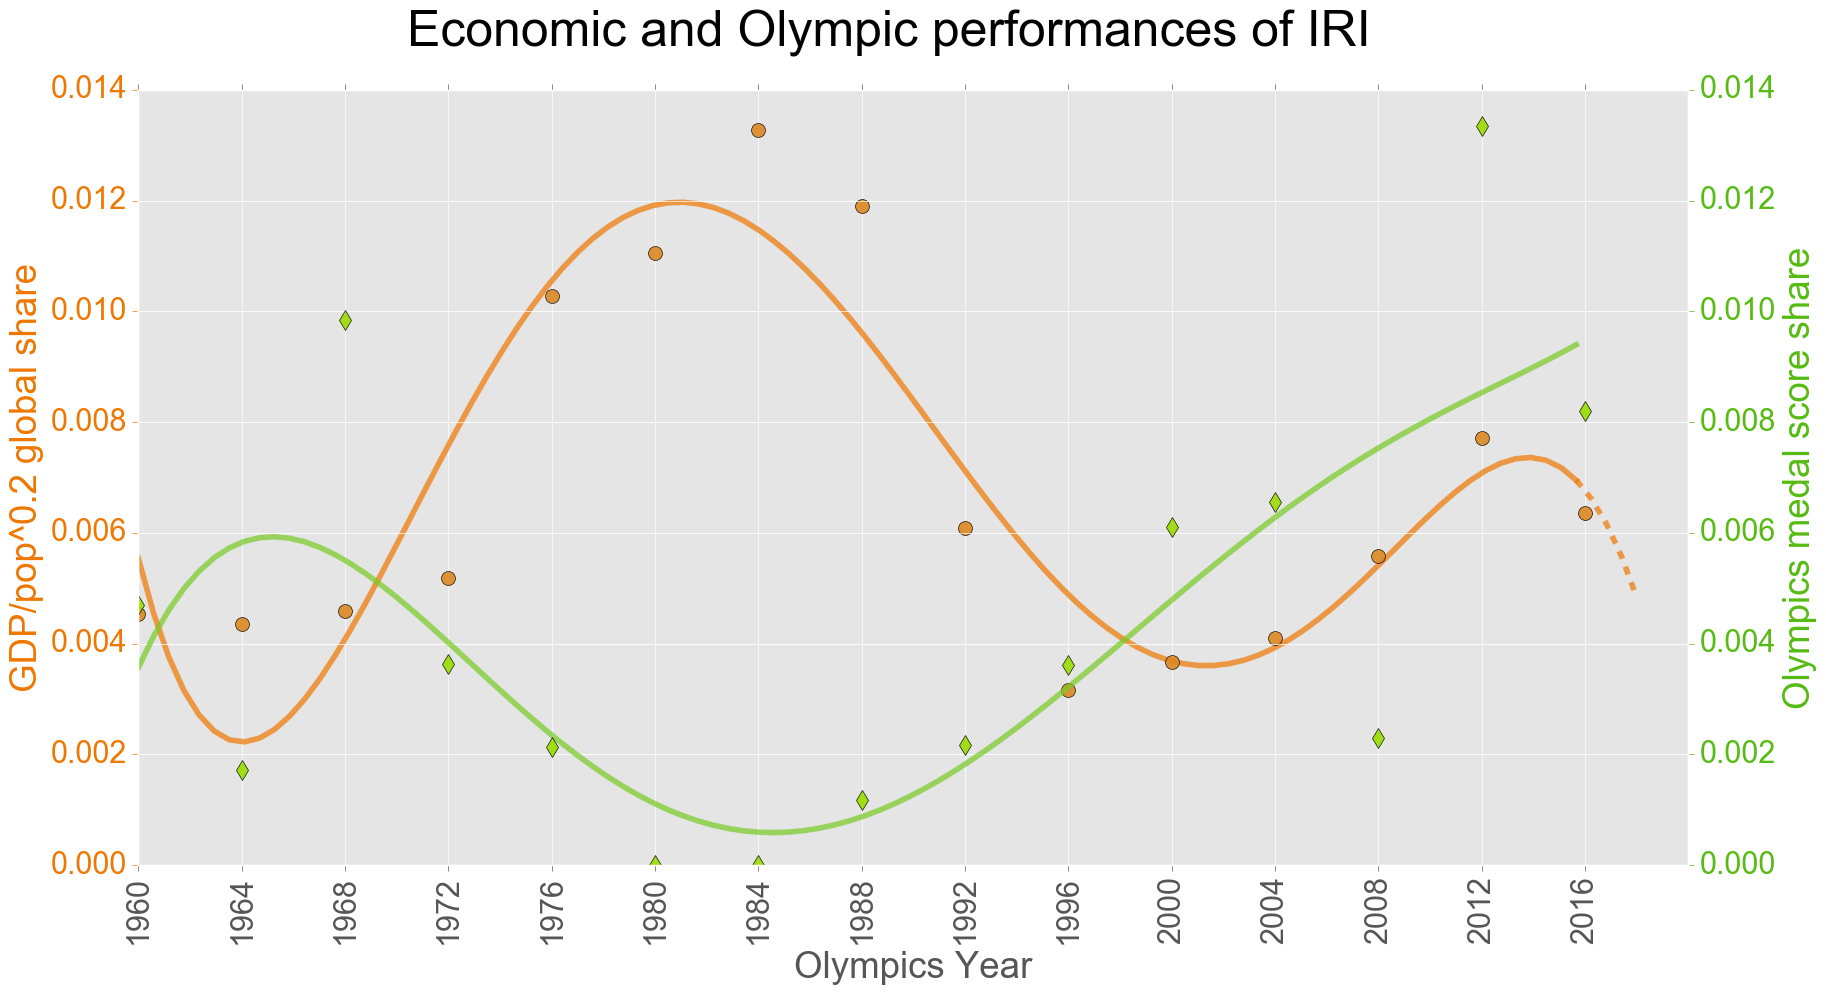

Figure 7 a-d: The economy and Summer Olympics performance trends of 4 other countries.


In [58]:
import warnings
warnings.filterwarnings("ignore", category=np.RankWarning)

# Rescaling the GDP/pop^0.2 share y-axis to reflect the range of the Olympics y-axis. Units are
    # arbitrary and show relative global share; similar range allows visual judgement of correlation.
ADJ_YBOUND_DICT = {"USA":0.6,"GER":0.2,"GBR":0.12,"FRA":0.08,"ITA":0.1,"CAN":0.1,"AUS":0.04,"BRA":0.04,\
                      "RUS":0.04,"ESP":0.07,"IND":0.03,"NED":0.03,"MEX":0.03,"SWE":0.03,"COL":0.01}

def adjust_ybounds_from_dict (plot_ax, noc):
    if (noc in ADJ_YBOUND_DICT):
        plot_ax[0].set_ybound(upper=ADJ_YBOUND_DICT[noc])
    return


for noc in g3_4y_share_df.index[:16]:  # magic number: 16
    plot_ax = plot_ctr_gdp_olymp_jux([noc])
    adjust_ybounds_from_dict(plot_ax, noc)
    plt.show()

print ("Figure 6 a-p: Diagrams showing the economy and Olympics performance trends of the top-economy")
print ("nations revealing strong correlations of the two metrics used for most of these countries.")

for noc in ["JAM","SWE","COL","IRI"]:  # magic number: 16
    plot_ax = plot_ctr_gdp_olymp_jux([noc])
    adjust_ybounds_from_dict(plot_ax, noc)
    plt.show()

print ("Figure 7 a-d: The economy and Summer Olympics performance trends of 4 other countries.")

warnings.filterwarnings("default", category=np.RankWarning)
